In [1]:
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt

Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [02:28<25:02,  7.35it/s]

(801, 801)


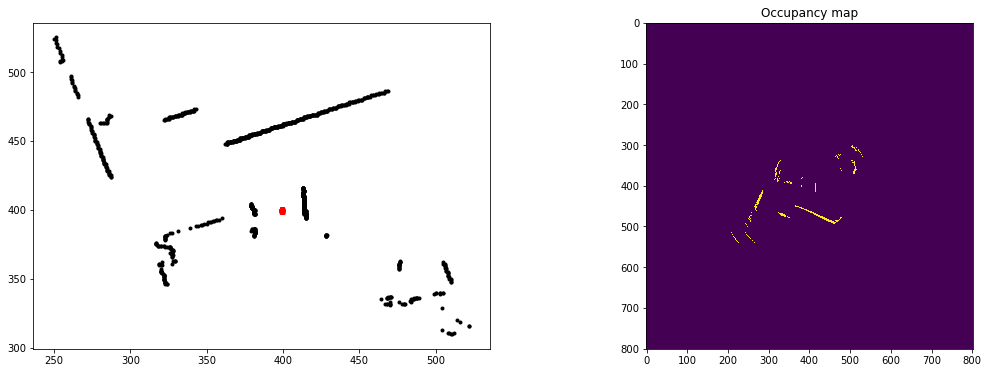

 17%|█▋        | 1999/12047 [05:04<23:25,  7.15it/s]  

(801, 801)


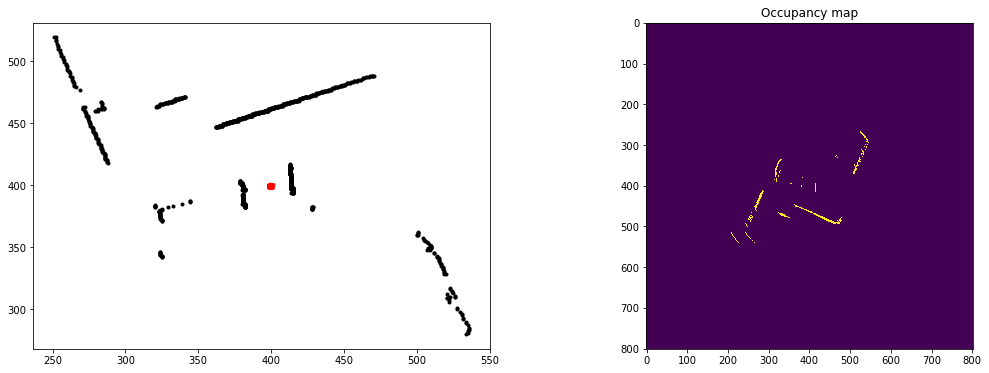

 25%|██▍       | 2999/12047 [07:33<20:28,  7.36it/s]  

(801, 801)


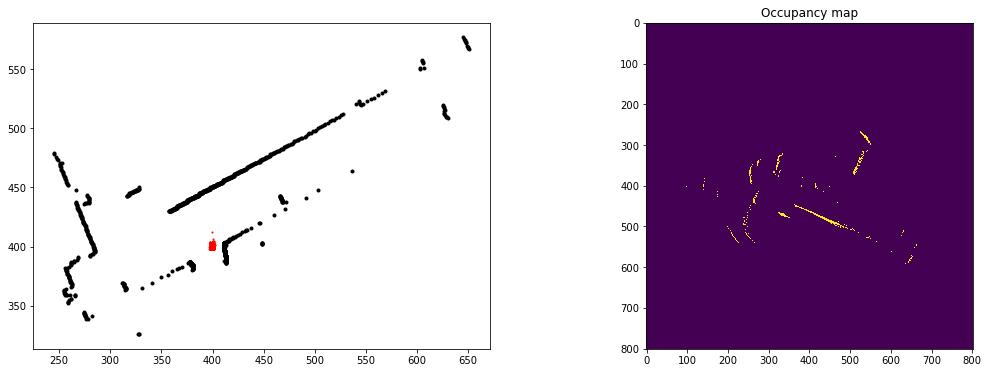

 33%|███▎      | 3999/12047 [10:05<20:42,  6.48it/s]  

(801, 801)


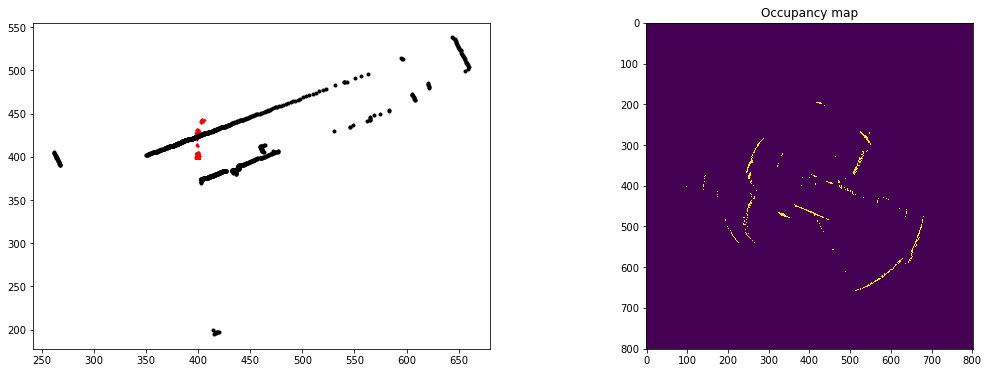

 41%|████▏     | 4999/12047 [13:11<22:26,  5.23it/s]  

(801, 801)


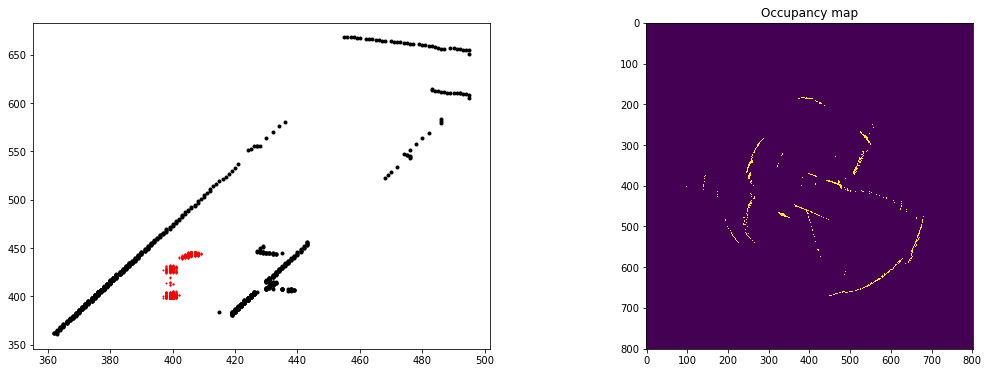

 50%|████▉     | 5999/12047 [16:26<21:24,  4.71it/s]  

(801, 801)


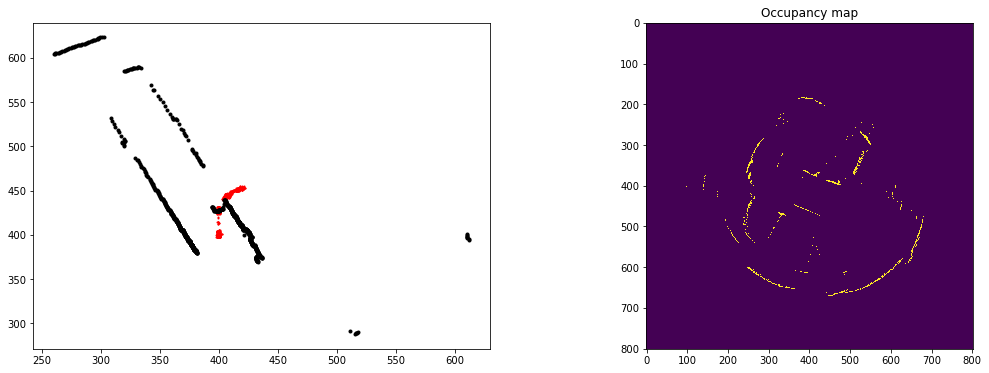

 58%|█████▊    | 6999/12047 [19:05<12:32,  6.71it/s]  

(801, 801)


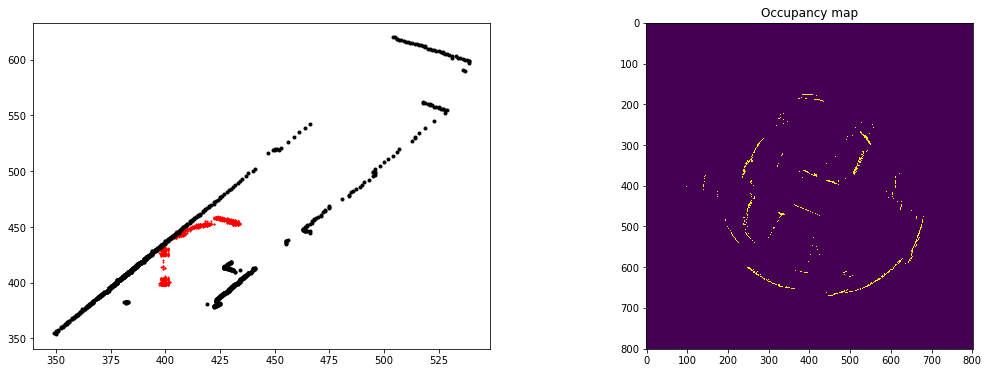

 66%|██████▋   | 7999/12047 [21:50<10:00,  6.74it/s]

(801, 801)


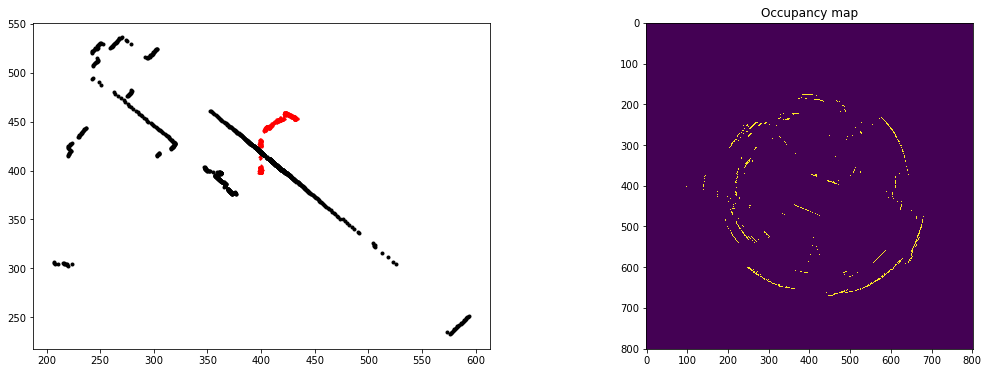

 75%|███████▍  | 8999/12047 [24:43<08:49,  5.75it/s]

(801, 801)


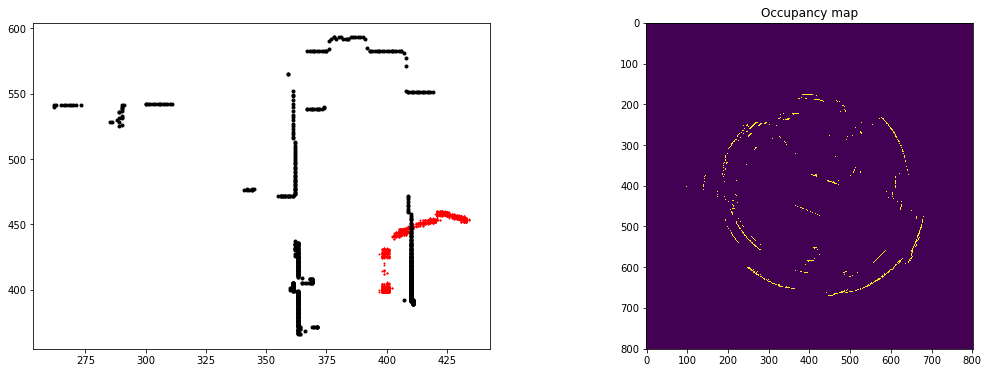

 83%|████████▎ | 9999/12047 [27:21<04:56,  6.92it/s]

(801, 801)


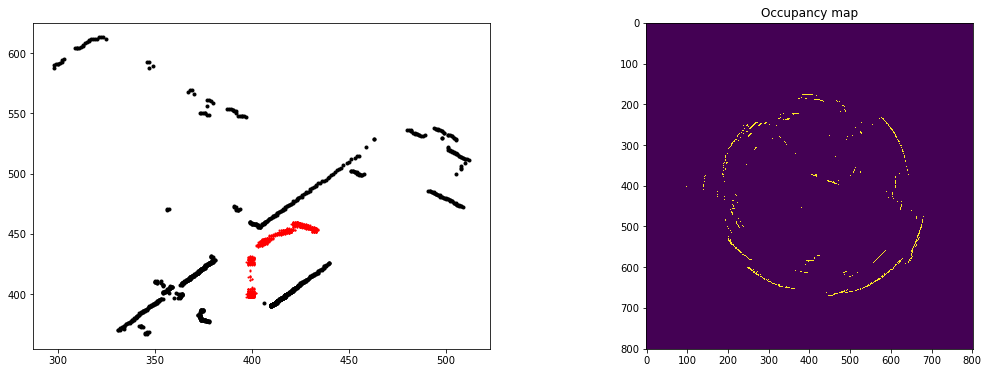

 91%|█████████▏| 10999/12047 [29:56<02:38,  6.62it/s]

(801, 801)


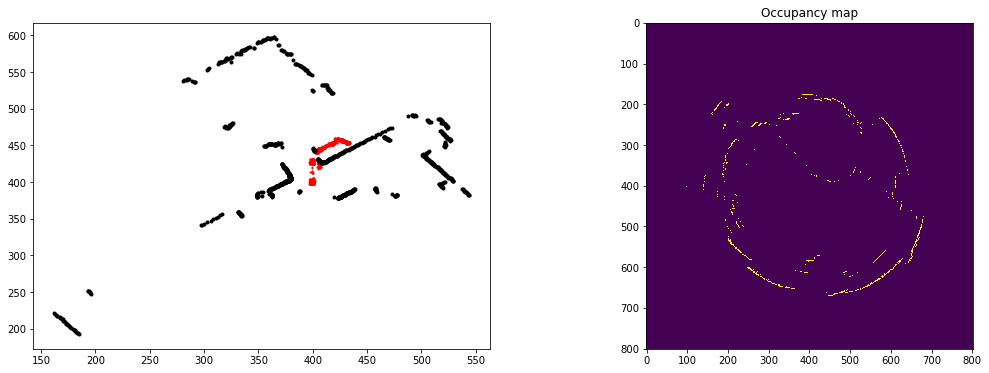

100%|█████████▉| 11999/12047 [32:38<00:07,  6.55it/s]

(801, 801)


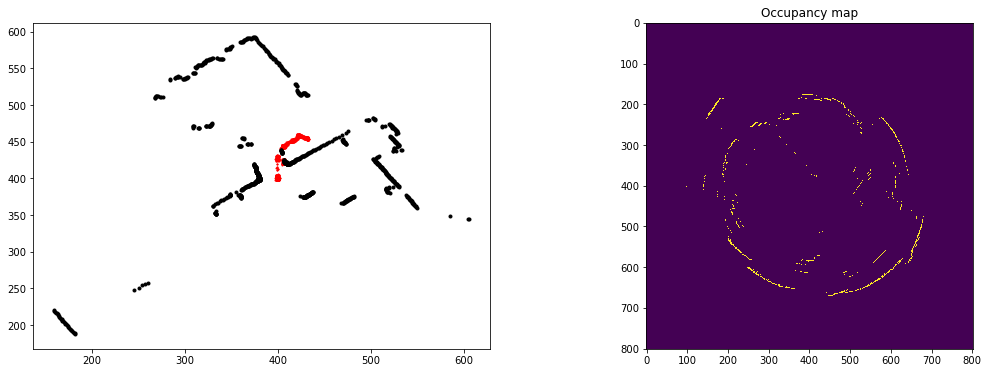

100%|██████████| 12047/12047 [32:47<00:00,  5.97it/s]

Time taken 1967.8955783843994


In [2]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 20
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #MAP,xs0,ys0 = update_and_map(np_lidar_scan[:,cur_scan],np_lidar_delta_pose[:,cur_scan],MAP,odometry_data['head_angles'][:,cur_scan])
        #### Update the Map based on Lidar Reading #####
        cur_pose = cur_pose + np_lidar_delta_pose[:,cur_scan]
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.03,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.03,1))) #Particular noise to x,y
            part_states[:,particle] = (noise + cur_pose).T
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
            #part_wghts[particle] = part_wghts[particle] * np.exp(part_corr[particle])
        
        

        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if(cur_scan % 1000 == 0):
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.2 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)


    ######## Update #########


        
some_weird_counter = 0

def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 
    xs0 = world[0,:].reshape(1,world.shape[1])
    ys0 = world[1,:].reshape(1,world.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          plt.plot(yis,xis,'.k')
          plt.scatter(MAP['y_loc'],MAP['x_loc'],s=1,c='r')

          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          #plt.xlabel("x")
          #plt.ylabel("y")
          #plt.title("Laser reading (red being robot location)")
          #plt.axis('equal')

          #plot map
          map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          print(map_threshold.shape)
          plt.imshow(map_threshold.T)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(9))
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)
        return MAP
    
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [4]:
########### Below is the code with log(6) confidencre




  0%|          | 0/12047 [00:00<?, ?it/s]

Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [02:44<29:35,  6.22it/s]

(801, 801)


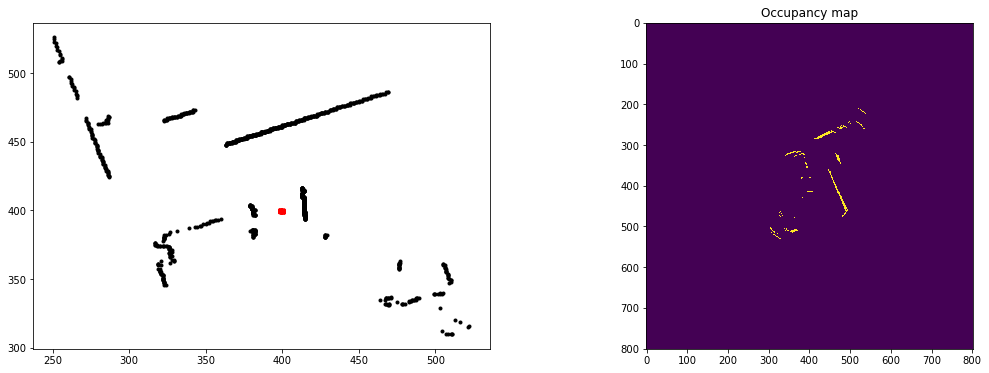

 17%|█▋        | 1999/12047 [05:18<25:36,  6.54it/s]  

(801, 801)


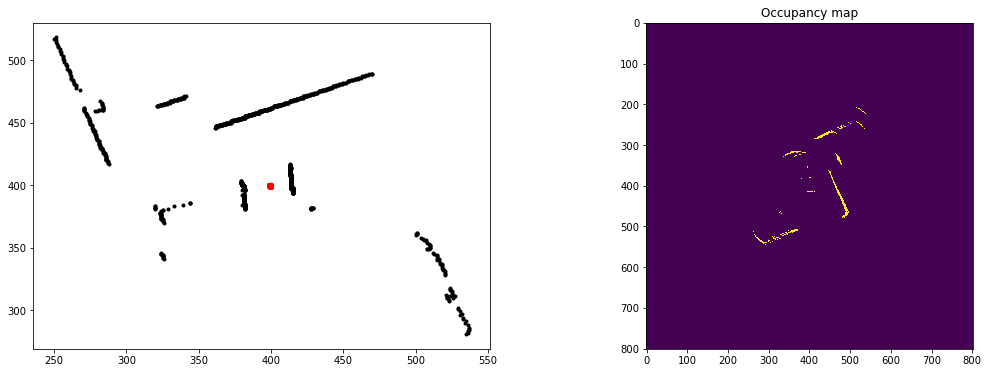

 25%|██▍       | 2999/12047 [07:57<22:24,  6.73it/s]  

(801, 801)


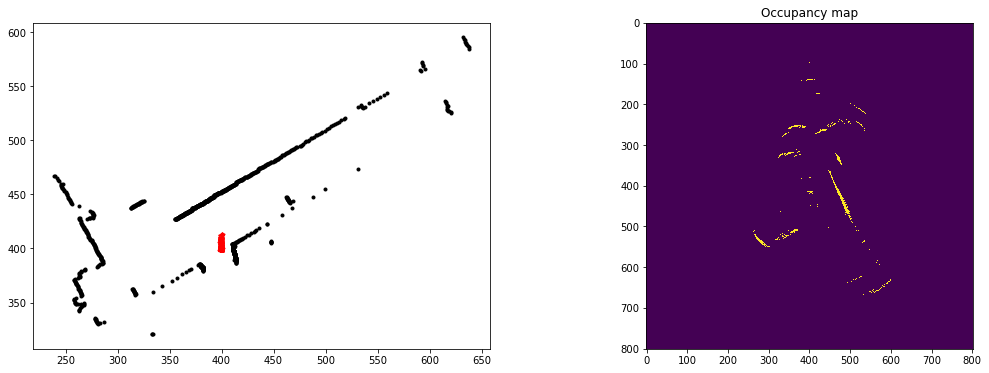

 33%|███▎      | 3999/12047 [10:44<20:48,  6.45it/s]  

(801, 801)


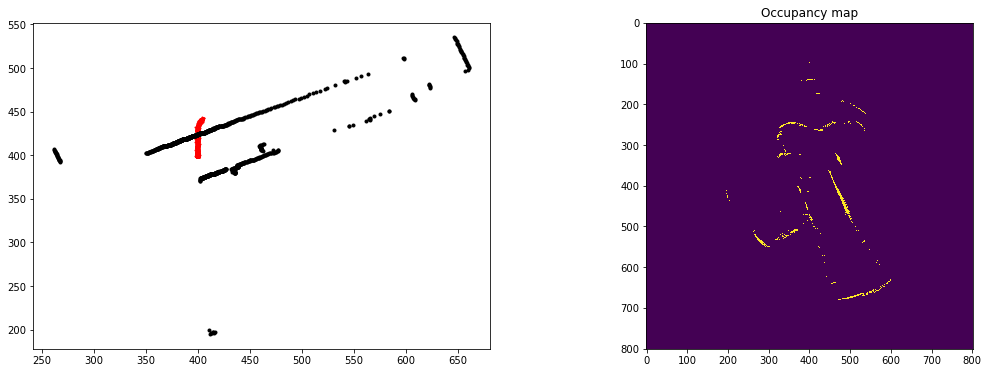

 41%|████▏     | 4999/12047 [13:23<21:32,  5.45it/s]  

(801, 801)


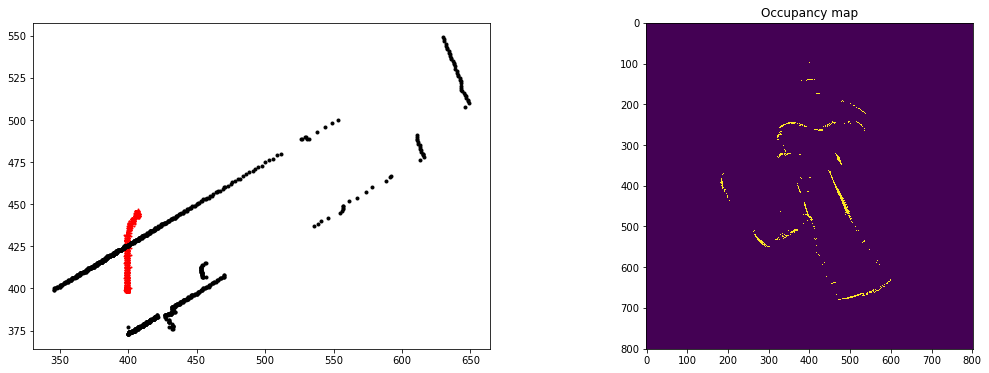

 50%|████▉     | 5999/12047 [16:15<16:47,  6.00it/s]  

(801, 801)


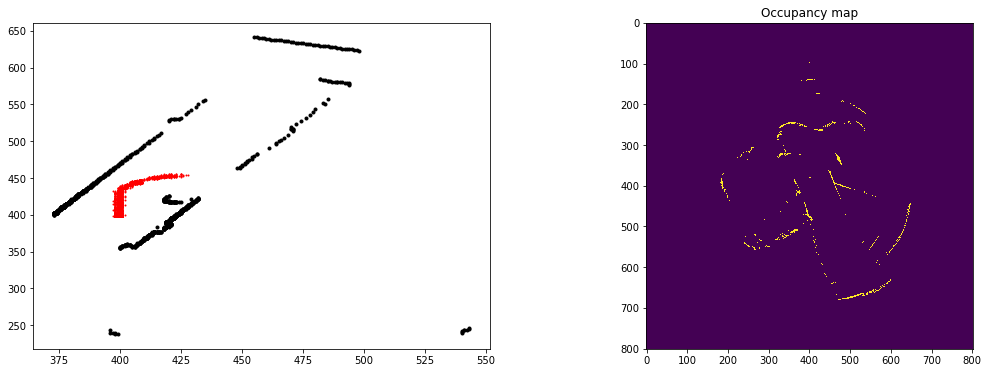

 58%|█████▊    | 6999/12047 [19:06<13:56,  6.03it/s]  

(801, 801)


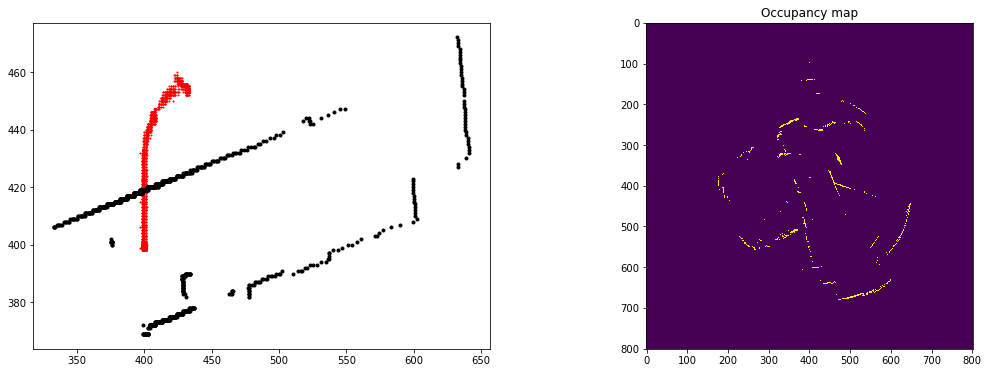

 66%|██████▋   | 7999/12047 [22:06<12:14,  5.51it/s]

(801, 801)


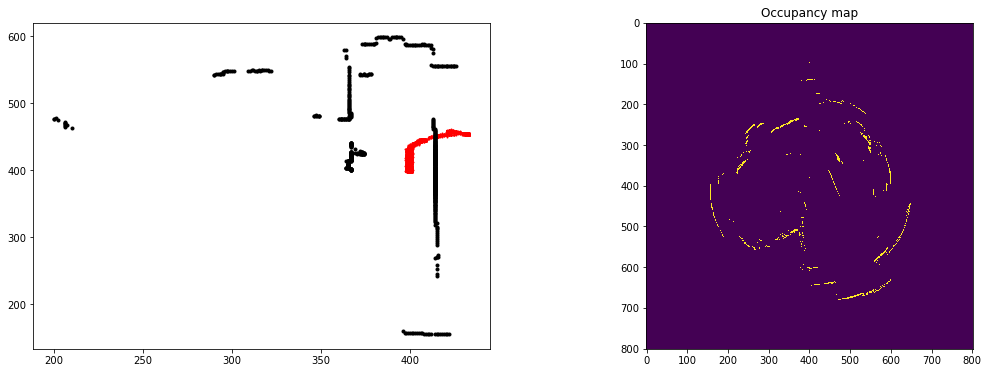

 75%|███████▍  | 8999/12047 [25:07<09:39,  5.26it/s]

(801, 801)


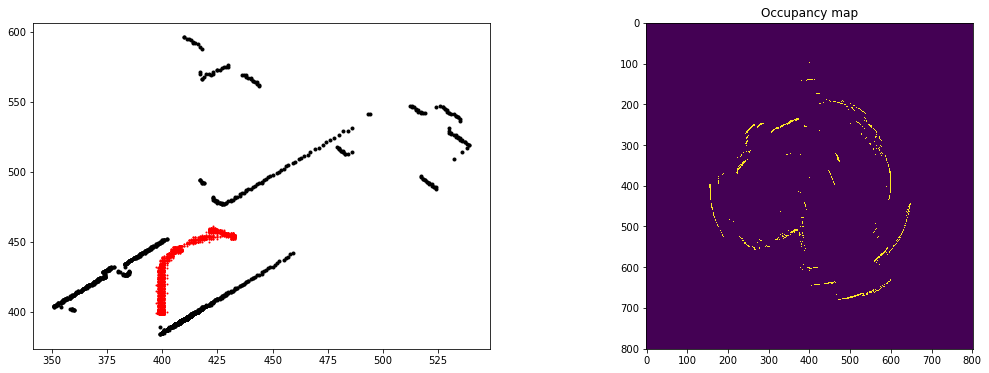

 83%|████████▎ | 9999/12047 [28:19<05:40,  6.01it/s]

(801, 801)


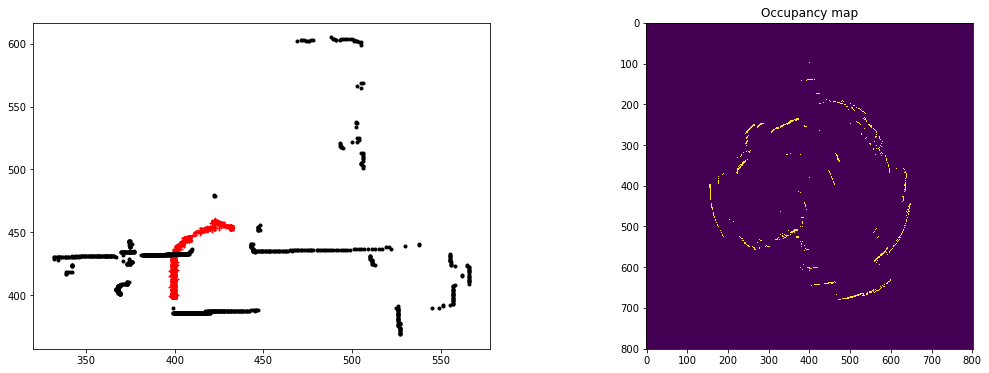

 91%|█████████▏| 10999/12047 [31:14<02:59,  5.83it/s]

(801, 801)


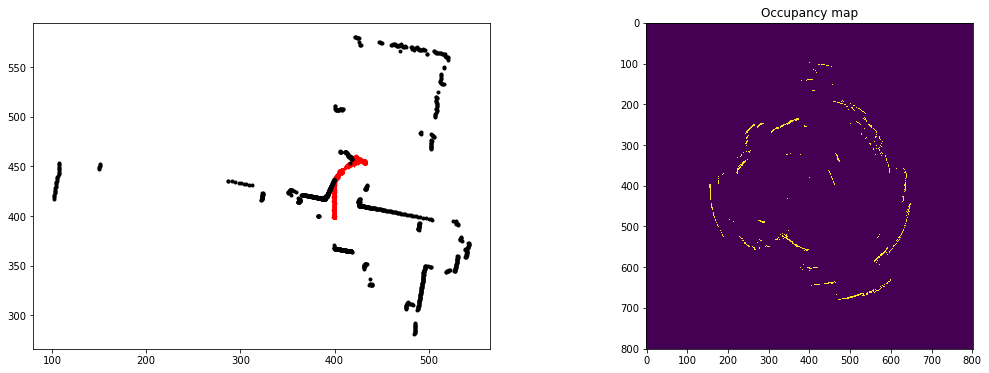

100%|█████████▉| 11999/12047 [34:14<00:08,  5.78it/s]

(801, 801)


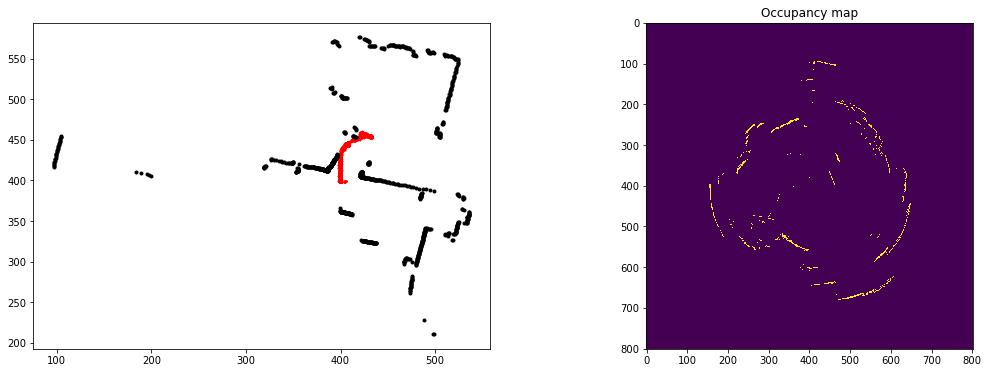

100%|██████████| 12047/12047 [34:24<00:00,  5.99it/s]

Time taken 2064.435010910034




















































In [2]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 20
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #MAP,xs0,ys0 = update_and_map(np_lidar_scan[:,cur_scan],np_lidar_delta_pose[:,cur_scan],MAP,odometry_data['head_angles'][:,cur_scan])
        #### Update the Map based on Lidar Reading #####
        cur_pose = cur_pose + np_lidar_delta_pose[:,cur_scan]
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.03,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.03,1))) #Particular noise to x,y
            part_states[:,particle] = (noise + cur_pose).T
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
            #part_wghts[particle] = part_wghts[particle] * np.exp(part_corr[particle])
        
        

        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if(cur_scan % 1000 == 0):
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.2 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)
    for i in range(50):
        print('\007')


    ######## Update #########


        
some_weird_counter = 0

def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 
    xs0 = world[0,:].reshape(1,world.shape[1])
    ys0 = world[1,:].reshape(1,world.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          plt.plot(yis,xis,'.k')
          plt.scatter(MAP['y_loc'],MAP['x_loc'],s=1,c='r')

          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          #plt.xlabel("x")
          #plt.ylabel("y")
          #plt.title("Laser reading (red being robot location)")
          #plt.axis('equal')

          #plot map
#           map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
#           map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          print(map_threshold.shape)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(6))
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)
        return MAP
    
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [4]:
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt
######## Here is fix for particle position update and noise reduced########




  0%|          | 0/12047 [00:00<?, ?it/s]

Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [03:04<31:40,  5.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


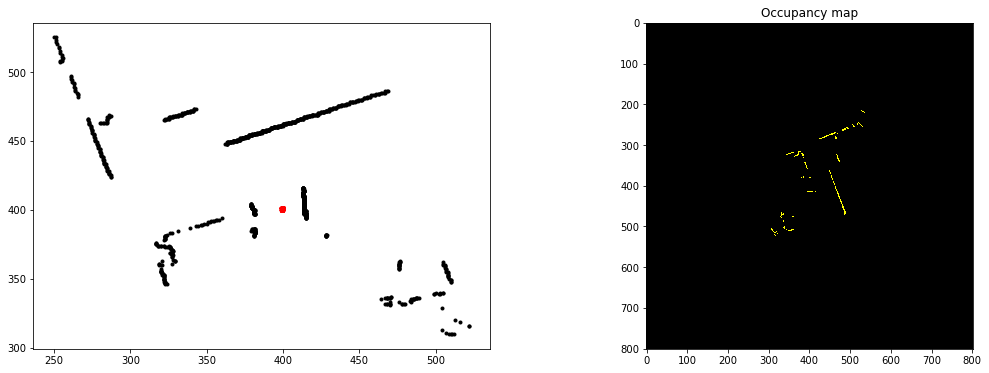

 17%|█▋        | 1999/12047 [06:14<32:47,  5.11it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


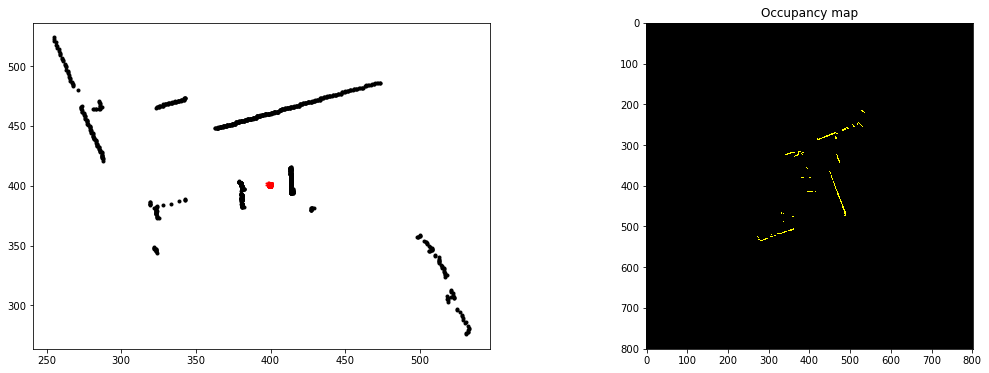

 25%|██▍       | 2999/12047 [09:25<28:20,  5.32it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


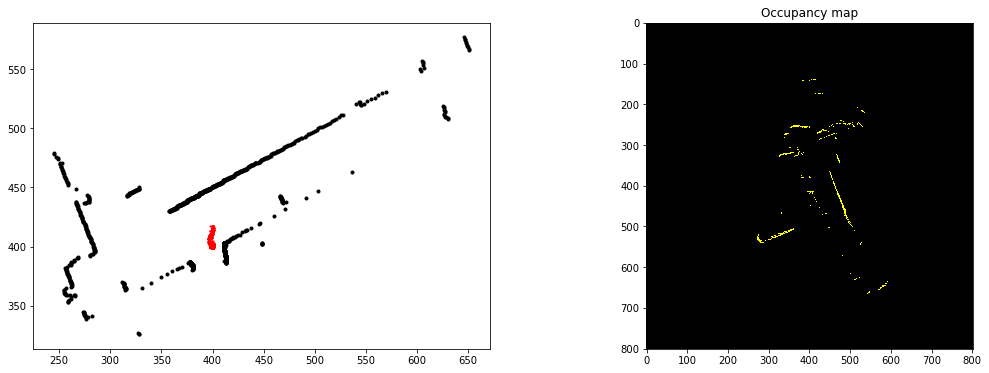

 33%|███▎      | 3999/12047 [12:38<24:14,  5.53it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


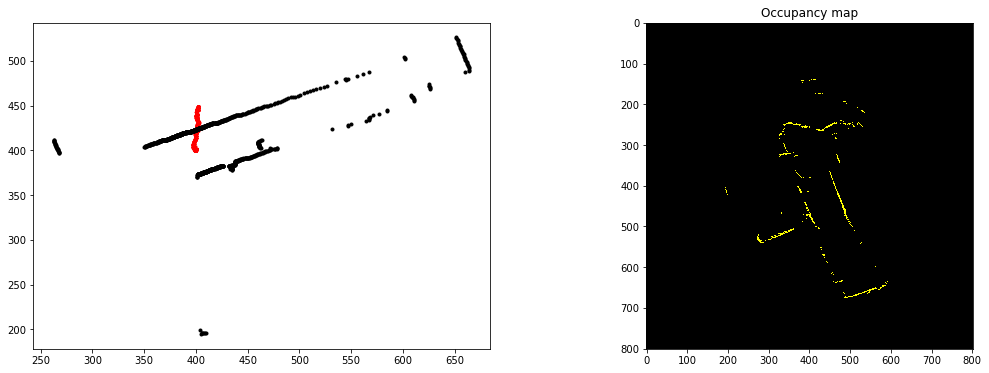

 41%|████▏     | 4999/12047 [15:43<20:31,  5.72it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


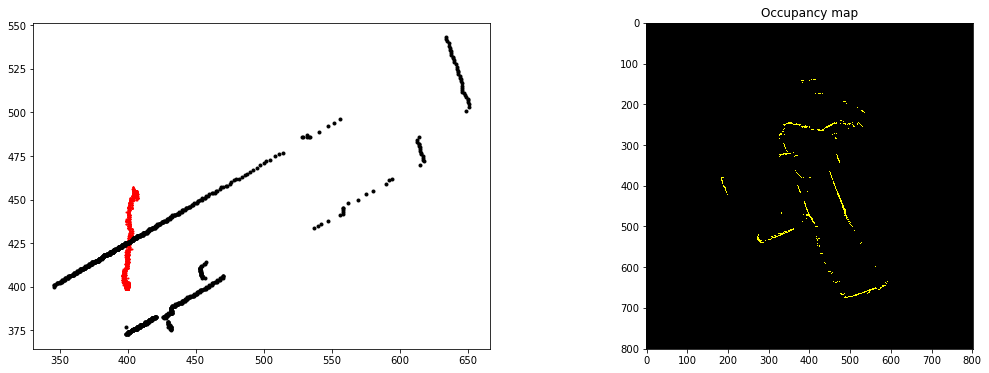

 50%|████▉     | 5999/12047 [18:44<16:05,  6.26it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


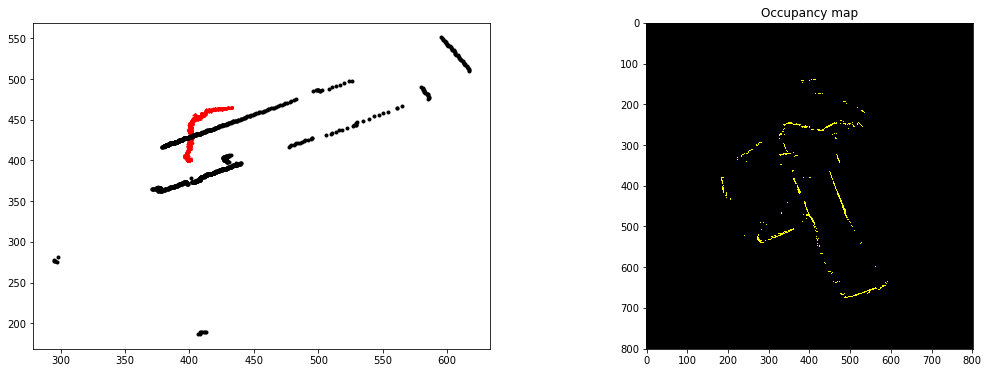

 58%|█████▊    | 6999/12047 [21:33<13:59,  6.01it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


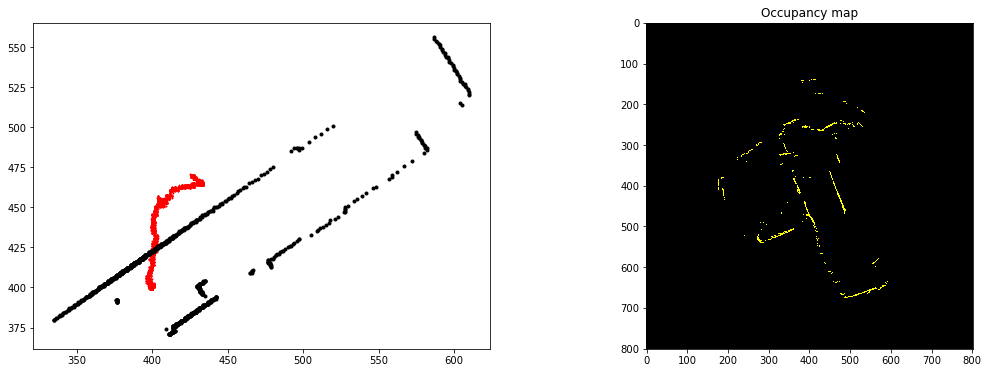

 66%|██████▋   | 7999/12047 [24:23<10:37,  6.35it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(801, 801, 3)


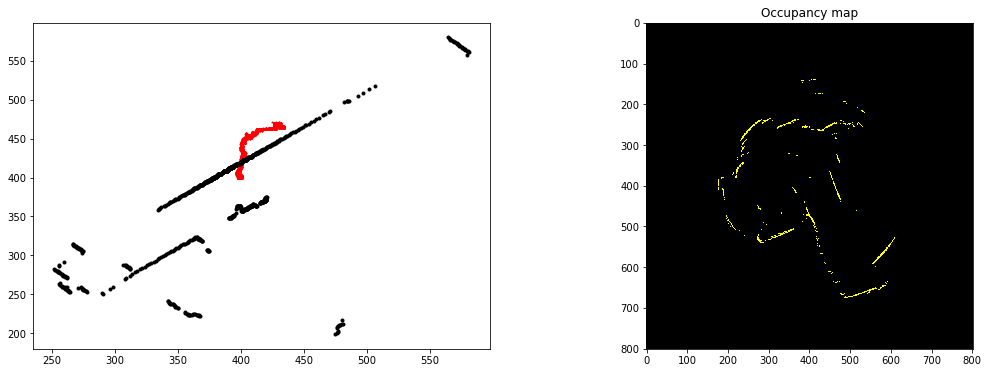

 75%|███████▍  | 8999/12047 [27:11<08:08,  6.24it/s]

In [ ]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 20
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #### Update the Map based on Lidar Reading #####
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.003,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.001,1))) #Particular noise to x,y
            #part_states[:,particle] = (noise + cur_pose).T
            part_states[:,particle] = noise + part_states[:,particle] + np_lidar_delta_pose[:,cur_scan]
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
        
        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if(cur_scan % 1000 == 0):
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.5 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)

    ######## Update #########


        
def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 
    xs0 = world[0,:].reshape(1,world.shape[1])
    ys0 = world[1,:].reshape(1,world.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          plt.plot(yis,xis,'.k')
          plt.scatter(MAP['y_loc'],MAP['x_loc'],s=1,c='r')

          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          #plt.xlabel("x")
          #plt.ylabel("y")
          #plt.title("Laser reading (red being robot location)")
          #plt.axis('equal')

          #plot map
          map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold[:,:,0] = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
          map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          print(map_threshold.shape)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(9))
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)
        return MAP
    
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [1]:
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt
######## Here is fix for wrong head angle removal and increased threshold######## - Helps remove the rotation effects




  0%|          | 0/12047 [00:00<?, ?it/s]

Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [02:16<30:33,  6.03it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


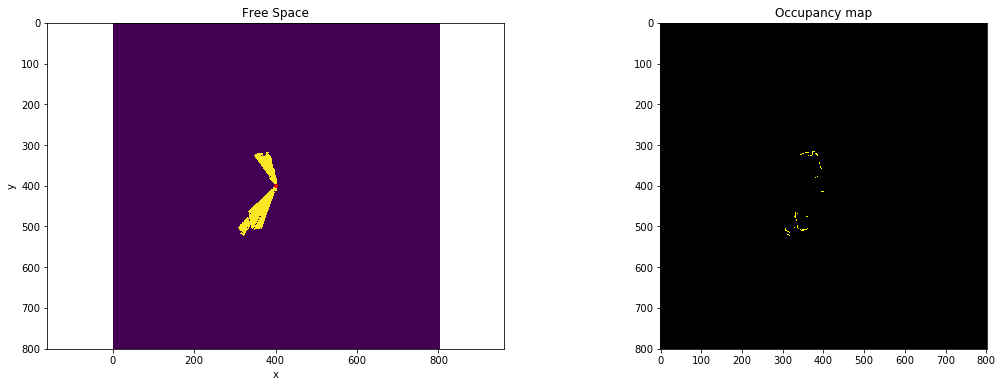

 17%|█▋        | 1999/12047 [04:35<20:30,  8.16it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


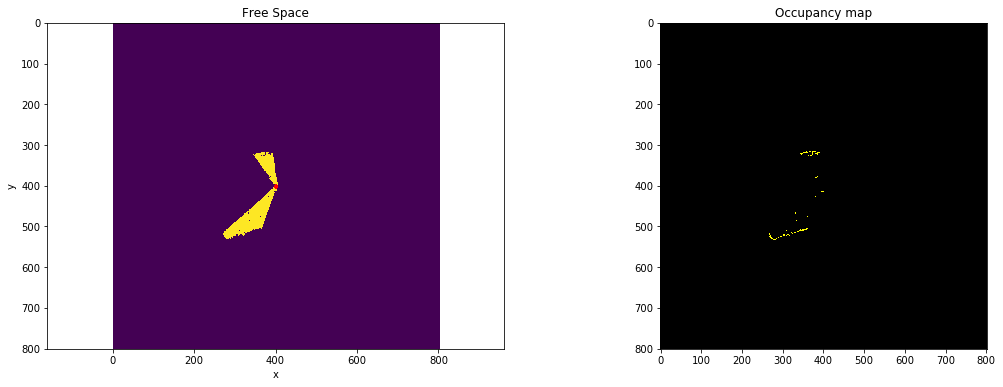

 25%|██▍       | 2999/12047 [06:52<20:46,  7.26it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


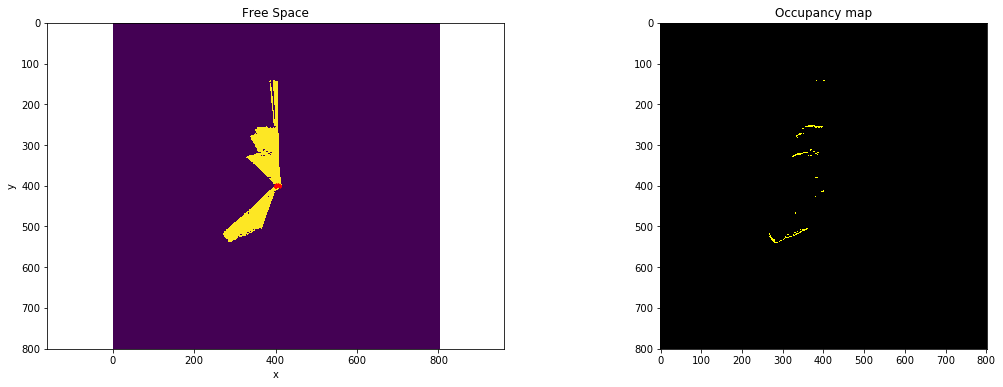

 33%|███▎      | 3999/12047 [09:06<19:53,  6.74it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


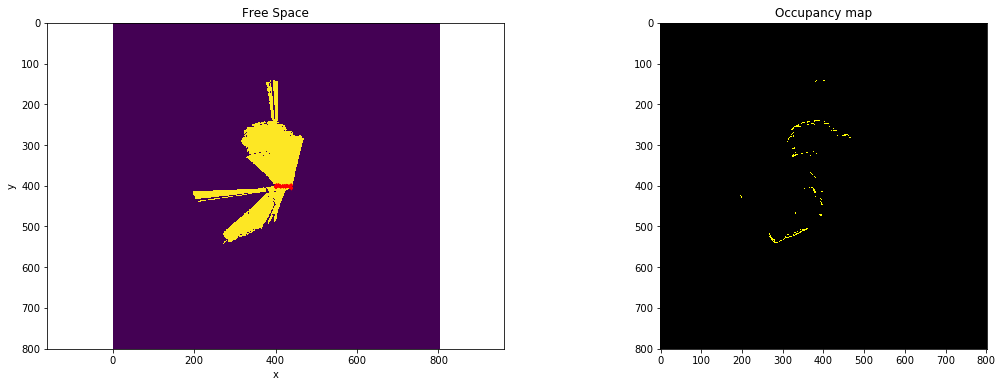

 41%|████▏     | 4999/12047 [11:33<15:45,  7.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


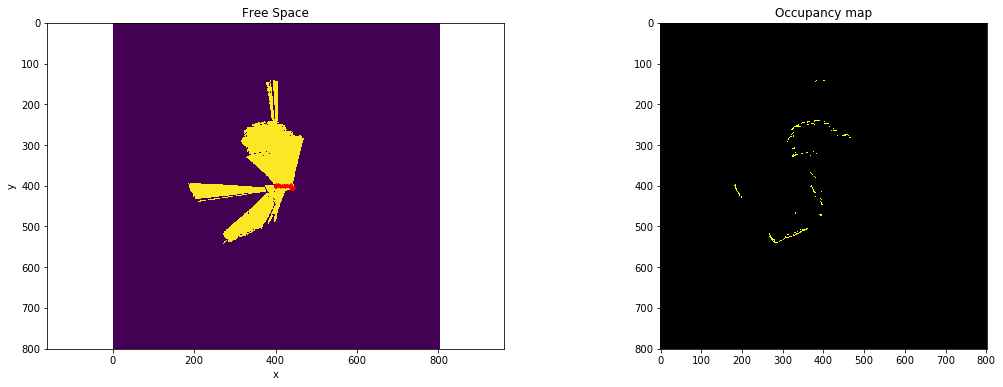

 50%|████▉     | 5999/12047 [13:47<15:31,  6.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


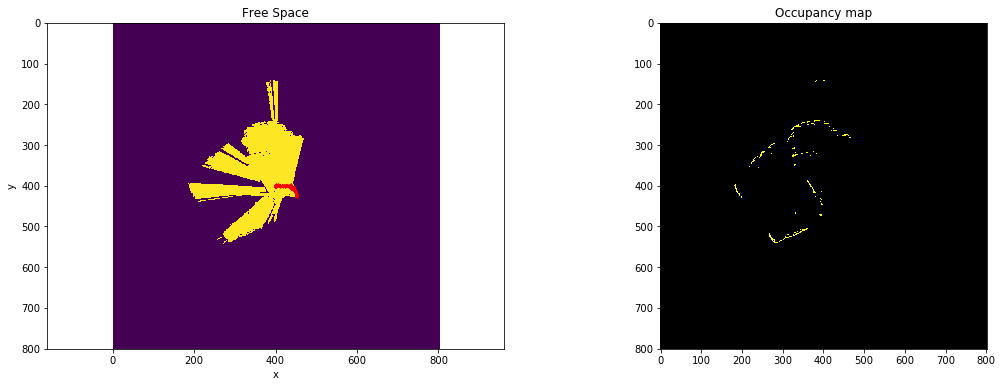

 58%|█████▊    | 6999/12047 [15:51<10:27,  8.04it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


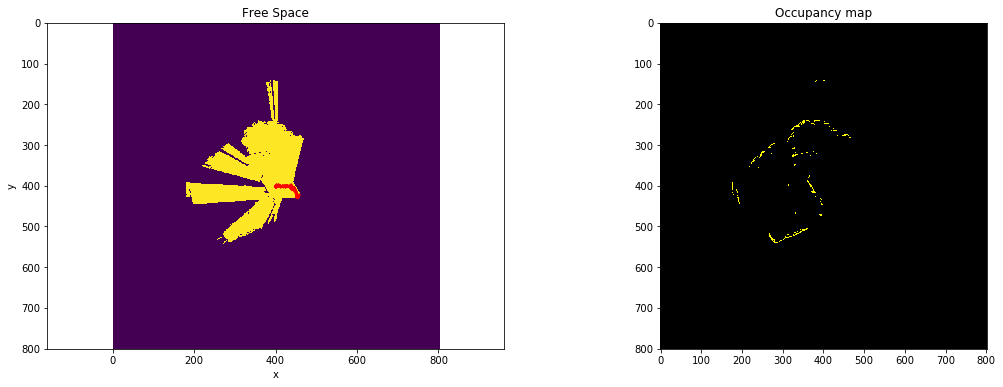

 66%|██████▋   | 7999/12047 [17:58<08:35,  7.85it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


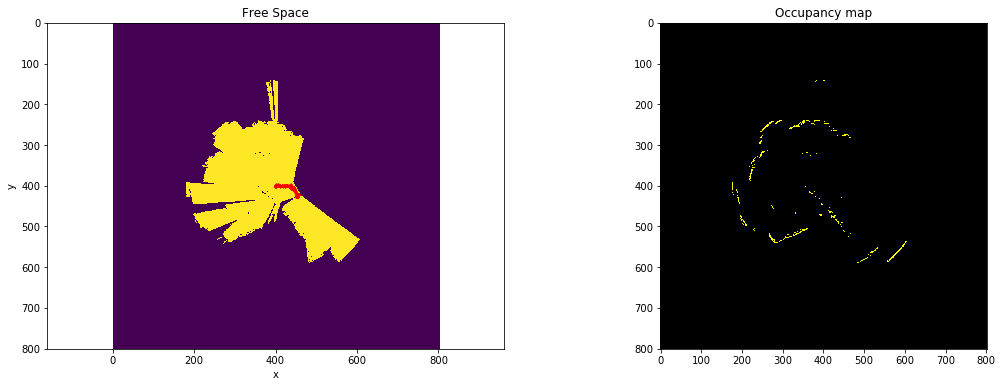

 75%|███████▍  | 8999/12047 [20:06<06:08,  8.27it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


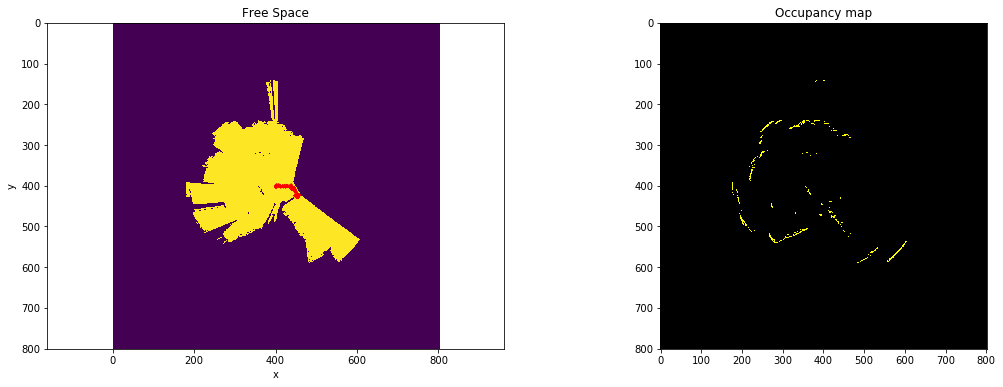

 83%|████████▎ | 9999/12047 [22:15<04:12,  8.11it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


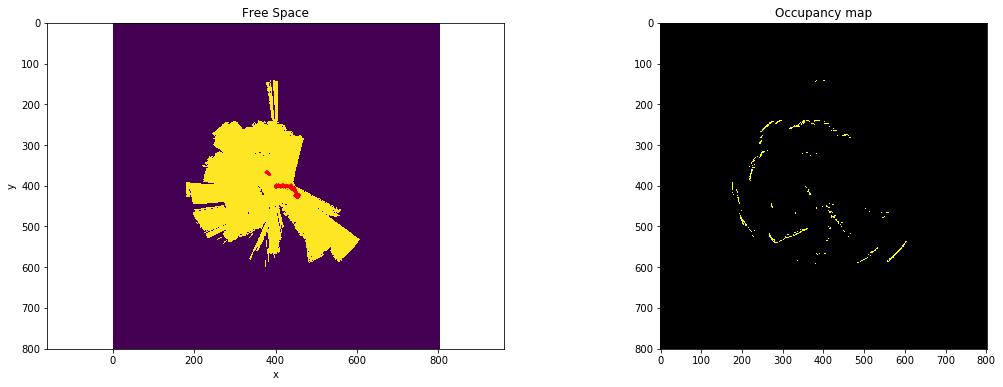

 91%|█████████▏| 10999/12047 [24:24<01:39, 10.53it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


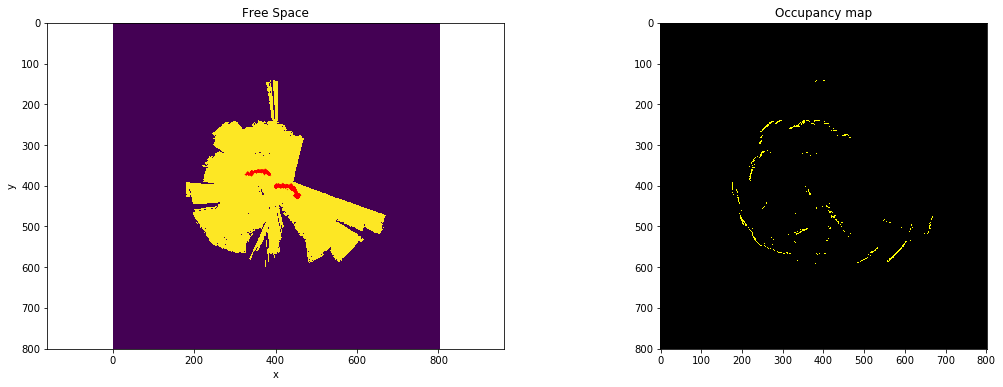

100%|█████████▉| 11999/12047 [26:33<00:06,  7.90it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


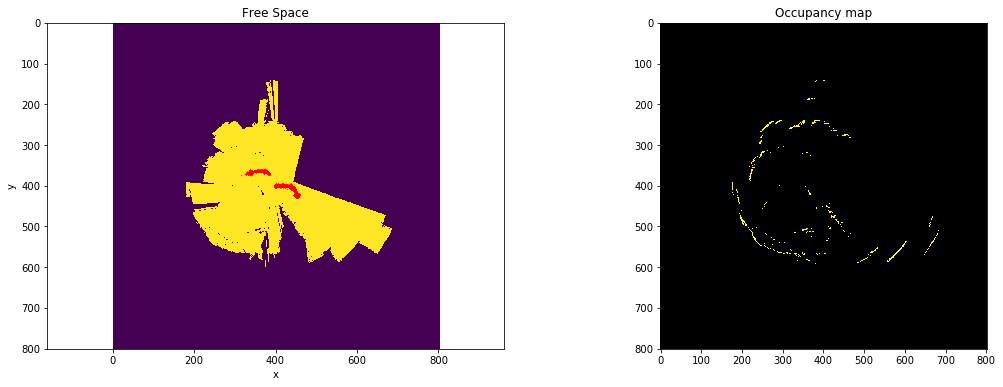

100%|█████████▉| 12046/12047 [26:40<00:00,  8.03it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


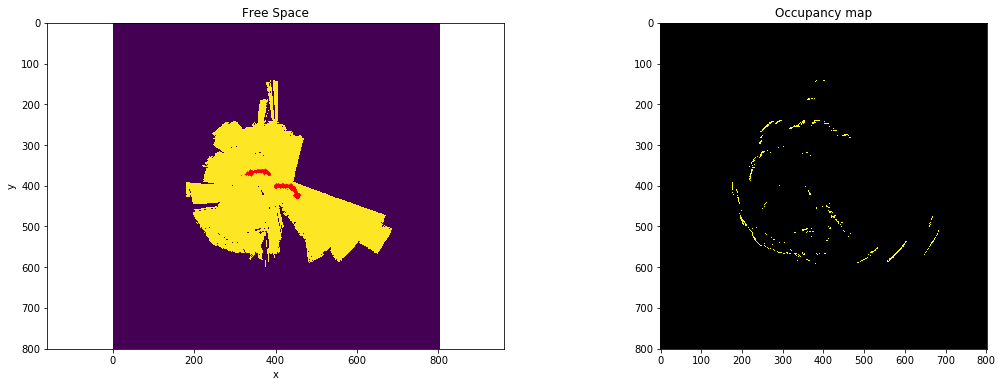

100%|██████████| 12047/12047 [26:41<00:00,  3.27it/s]

Time taken 1601.218987941742


In [2]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 20
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #### Update the Map based on Lidar Reading #####
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.003,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.001,1))) #Particular noise to x,y
            #part_states[:,particle] = (noise + cur_pose).T
            part_states[:,particle] = noise + part_states[:,particle] + np_lidar_delta_pose[:,cur_scan]
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
        
        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if((cur_scan % 1000 == 0) or (cur_scan == np_lidar_scan.shape[1]-1)) :
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.5 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)

    ######## Update #########


        
def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 

    ######## Drop Points that have negative z value in world frame ########
    world_T = world.T
    world_corrected = world_T[np.where(world[2,:] > 0)]
    world_corrected = world_corrected.T

    xs0 = world_corrected[0,:].reshape(1,world_corrected.shape[1])
    ys0 = world_corrected[1,:].reshape(1,world_corrected.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

      #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(9))
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)

     #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          #plt.plot(yis,xis,'.k')
          plt.scatter(MAP['x_loc'],MAP['y_loc'],s=0.1,c='r')

          map_threshold = np.zeros((map_shape))
          map_threshold = np.where(MAP['log_odds'] < 0,  np.full(map_shape,1),np.zeros(map_shape))

          plt.imshow(map_threshold)
          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          plt.xlabel("x")
          plt.ylabel("y")
          plt.title("Free Space")
          plt.axis('equal')

          #plot map
          map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold[:,:,0] = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
          map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    if(update_log_odds == True):
        return MAP
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [1]:
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt
######## Plotting free space and increased number of particles 2 times  ########


Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [04:55<53:31,  3.44it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


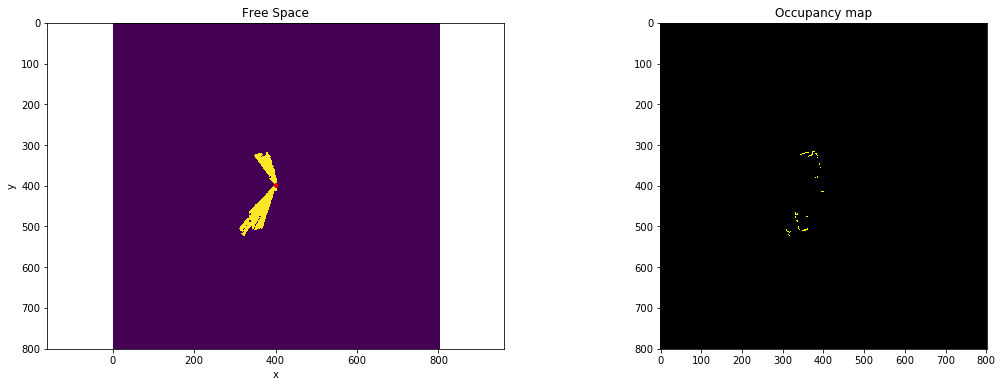

 17%|█▋        | 1999/12047 [09:50<50:16,  3.33it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


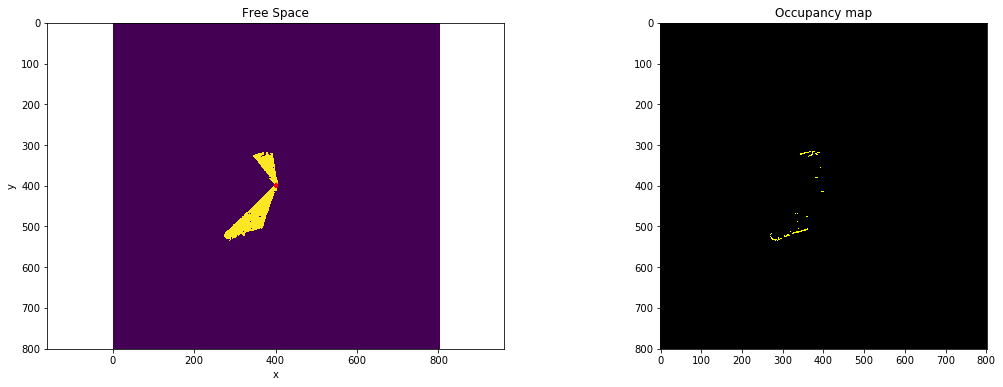

 25%|██▍       | 2999/12047 [14:53<45:48,  3.29it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


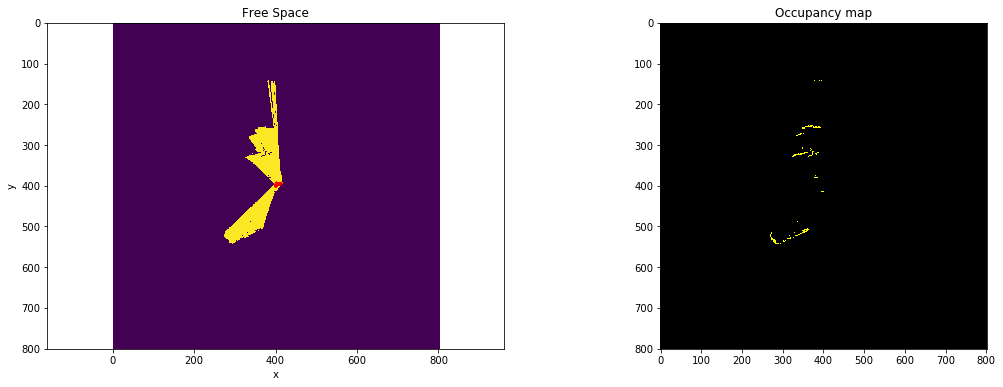

 33%|███▎      | 3999/12047 [19:53<40:52,  3.28it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


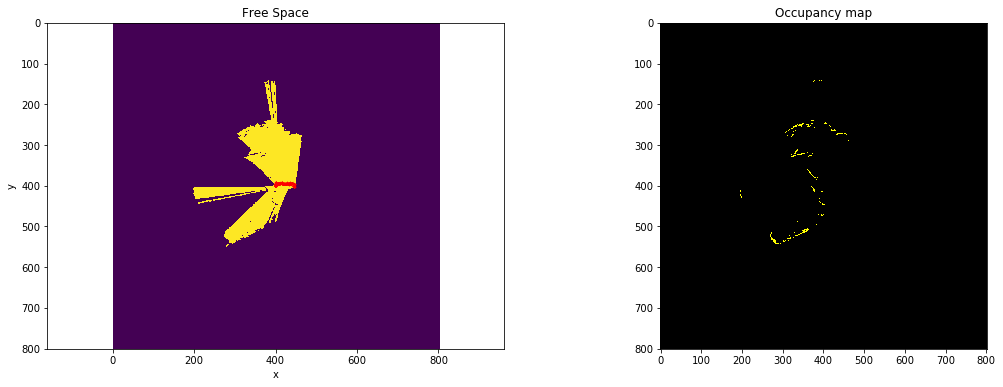

 41%|████▏     | 4999/12047 [24:49<35:11,  3.34it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


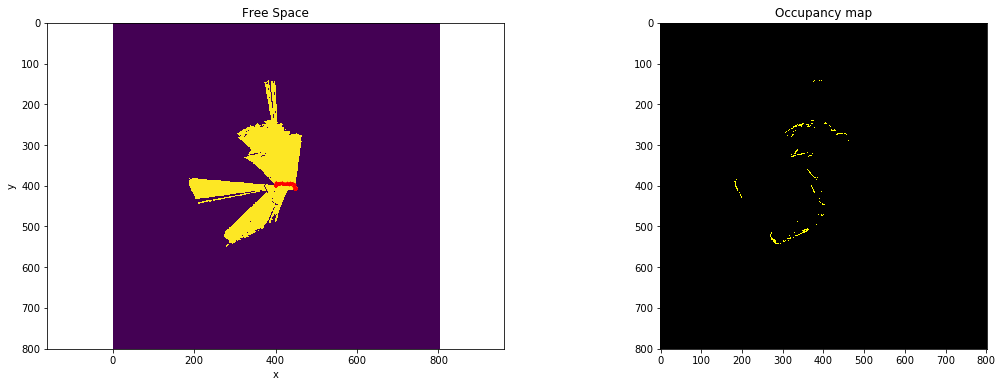

 50%|████▉     | 5999/12047 [29:38<27:22,  3.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


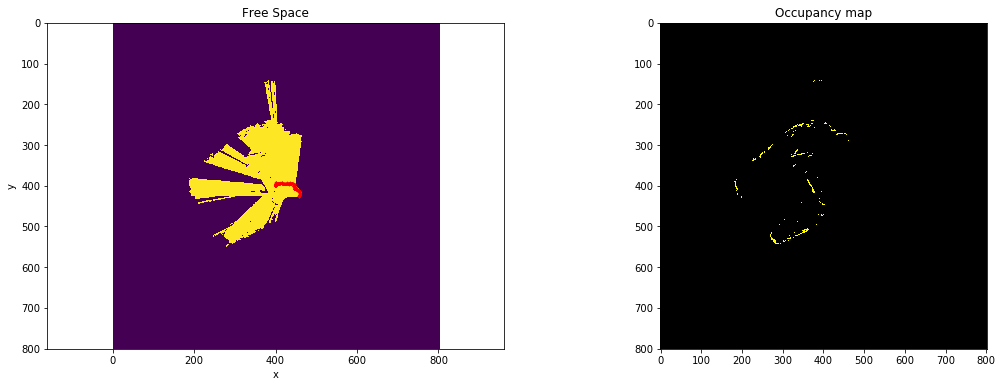

 58%|█████▊    | 6999/12047 [34:26<23:22,  3.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


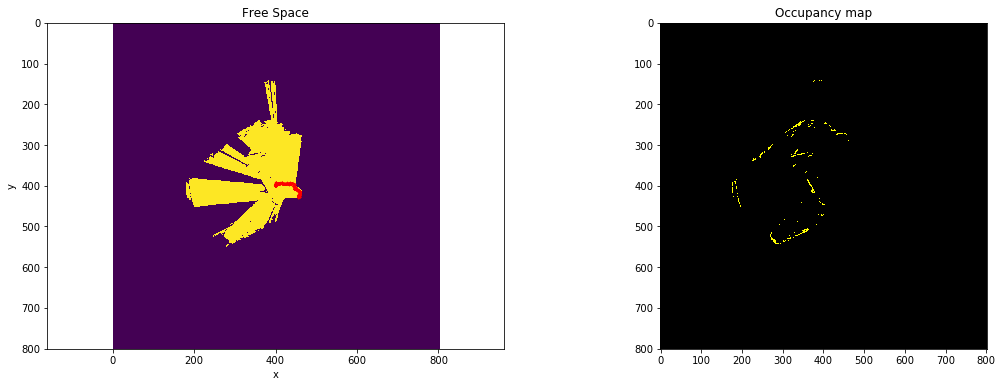

 66%|██████▋   | 7999/12047 [39:08<19:18,  3.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


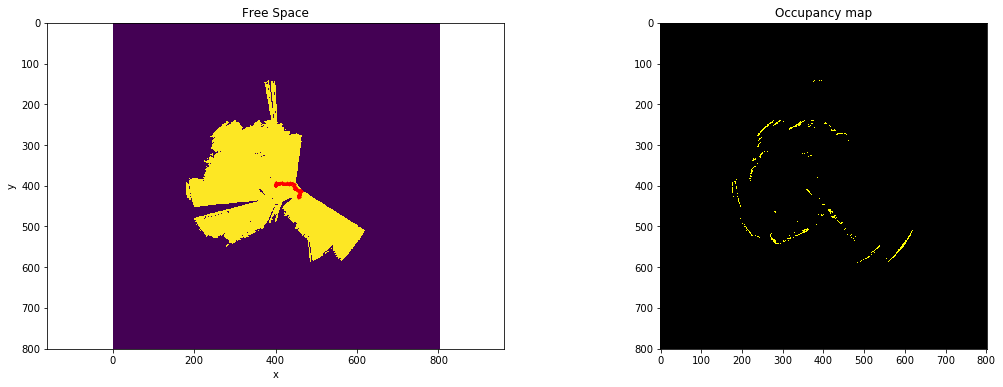

 75%|███████▍  | 8999/12047 [43:45<11:46,  4.32it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


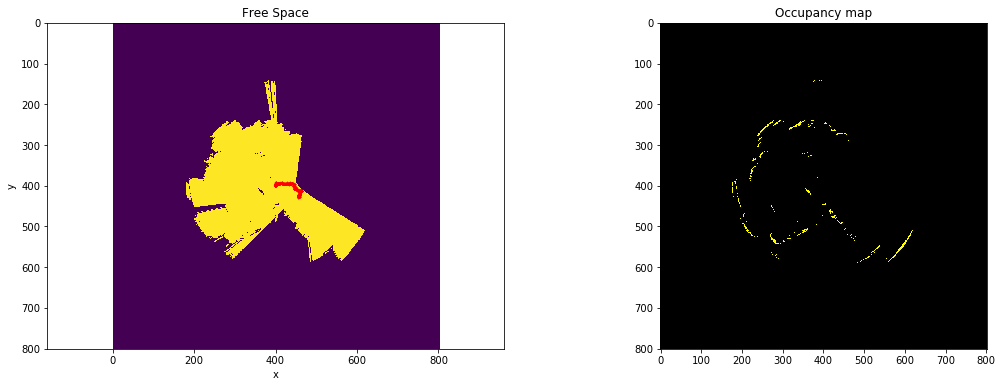

 83%|████████▎ | 9999/12047 [48:19<08:52,  3.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


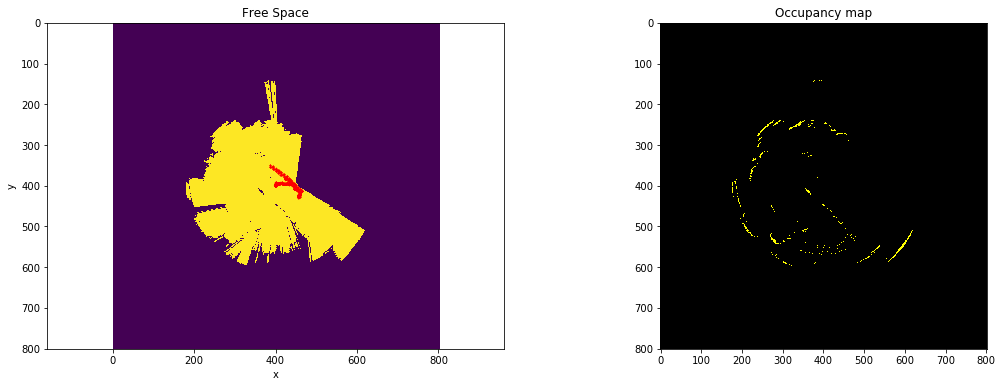

 91%|█████████▏| 10999/12047 [52:53<04:12,  4.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


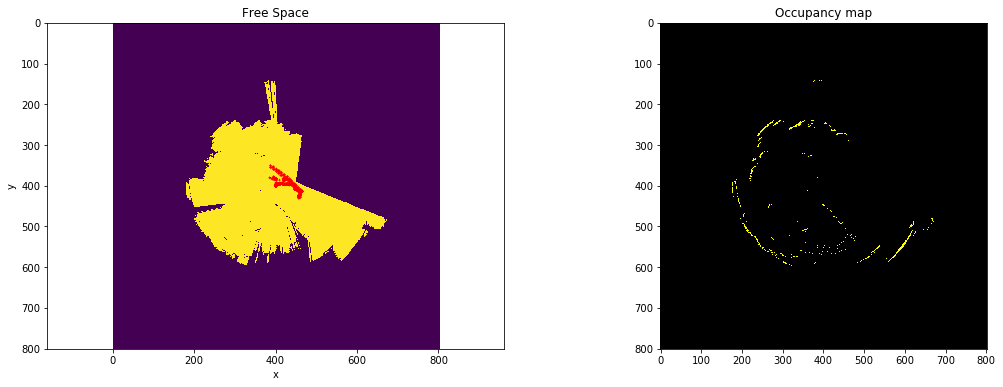

100%|█████████▉| 11999/12047 [57:31<00:14,  3.36it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


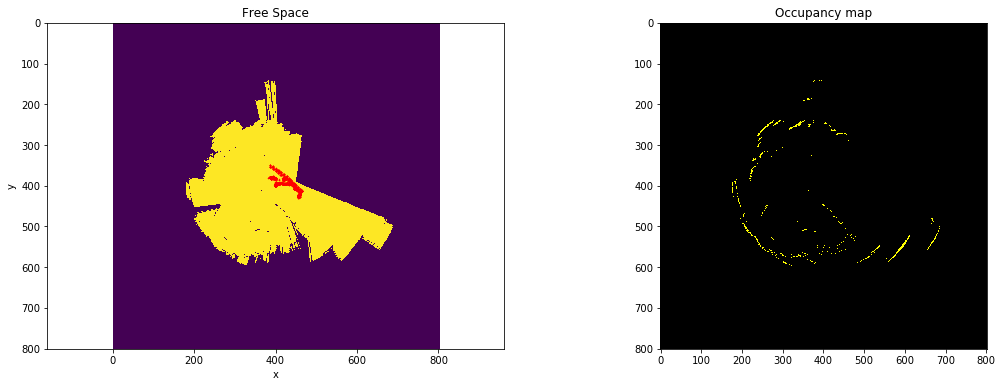

100%|█████████▉| 12046/12047 [57:44<00:00,  4.21it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


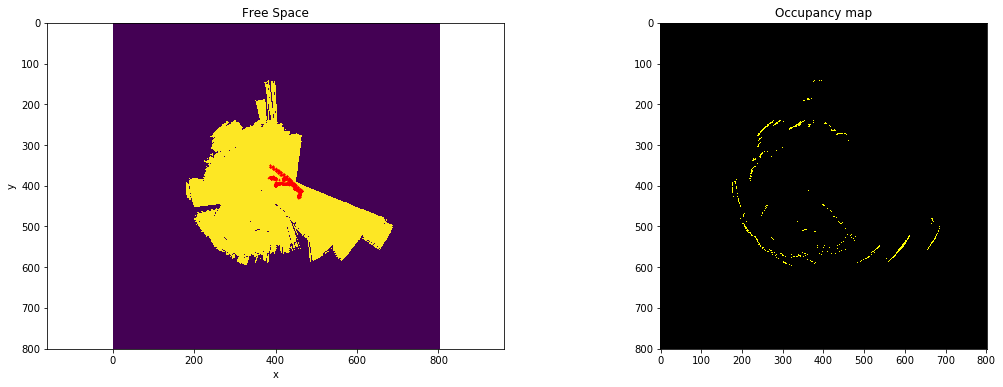

100%|██████████| 12047/12047 [57:45<00:00,  2.22it/s]

Time taken 3465.9670214653015


In [2]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 20 * 2
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #### Update the Map based on Lidar Reading #####
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.003,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.001,1))) #Particular noise to x,y
            #part_states[:,particle] = (noise + cur_pose).T
            part_states[:,particle] = noise + part_states[:,particle] + np_lidar_delta_pose[:,cur_scan]
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
        
        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if((cur_scan % 1000 == 0) or (cur_scan == np_lidar_scan.shape[1]-1)) :
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.5 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)

    ######## Update #########


        
def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 

    ######## Drop Points that have negative z value in world frame ########
    world_T = world.T
    world_corrected = world_T[np.where(world[2,:] > 0)]
    world_corrected = world_corrected.T

    xs0 = world_corrected[0,:].reshape(1,world_corrected.shape[1])
    ys0 = world_corrected[1,:].reshape(1,world_corrected.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

      #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(9))
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)

     #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          #plt.plot(yis,xis,'.k')
          plt.scatter(MAP['x_loc'],MAP['y_loc'],s=0.1,c='r')

          map_threshold = np.zeros((map_shape))
          map_threshold = np.where(MAP['log_odds'] < 0,  np.full(map_shape,1),np.zeros(map_shape))

          plt.imshow(map_threshold)
          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          plt.xlabel("x")
          plt.ylabel("y")
          plt.title("Free Space")
          plt.axis('equal')

          #plot map
          map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold[:,:,0] = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
          map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    if(update_log_odds == True):
        return MAP
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [1]:
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt
######## Capping the log odds  ######## - Number of particles does'nt seem to have much impact


Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [02:35<29:07,  6.32it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


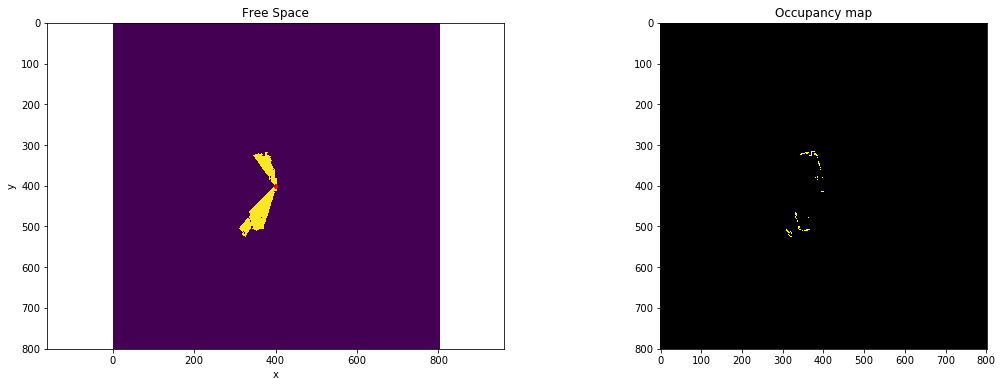

 17%|█▋        | 1999/12047 [05:14<25:04,  6.68it/s]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


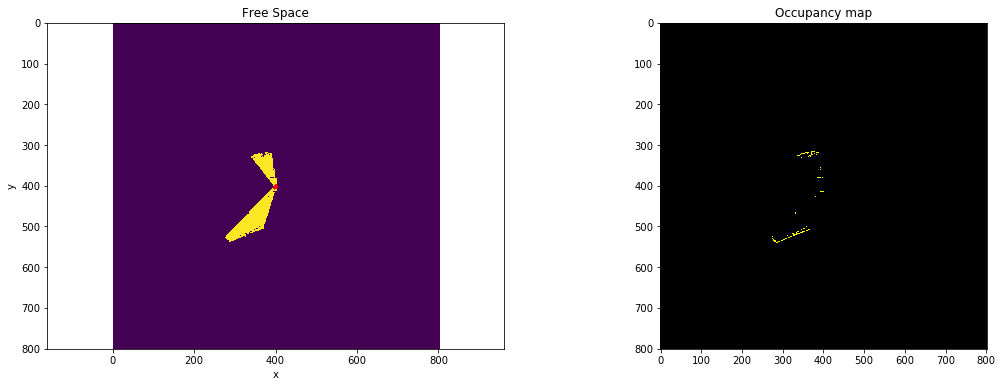

 25%|██▍       | 2999/12047 [07:51<24:07,  6.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


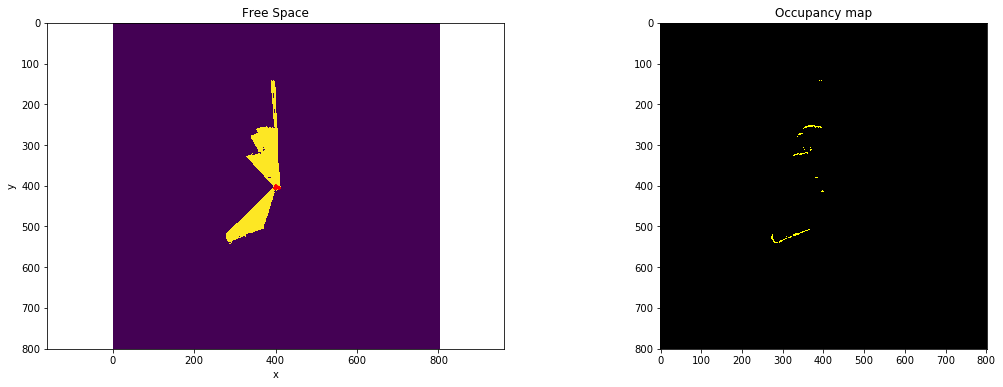

 33%|███▎      | 3999/12047 [10:29<16:34,  8.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


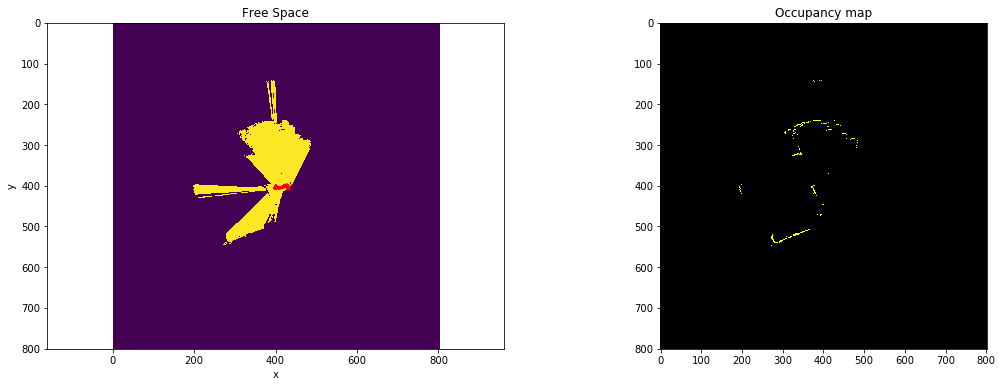

 41%|████▏     | 4999/12047 [13:06<18:07,  6.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


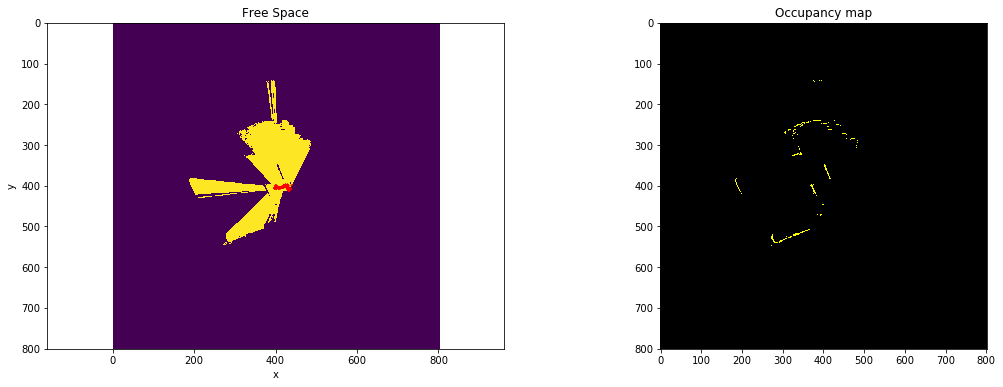

 50%|████▉     | 5999/12047 [15:39<16:07,  6.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


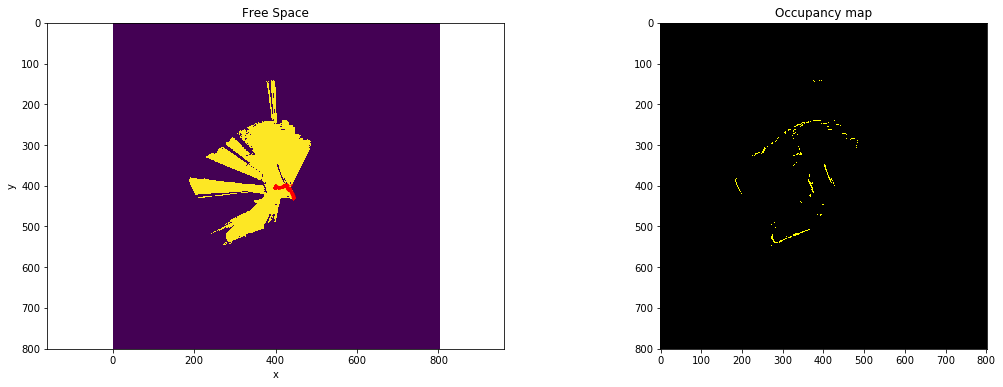

 58%|█████▊    | 6999/12047 [18:15<14:28,  5.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


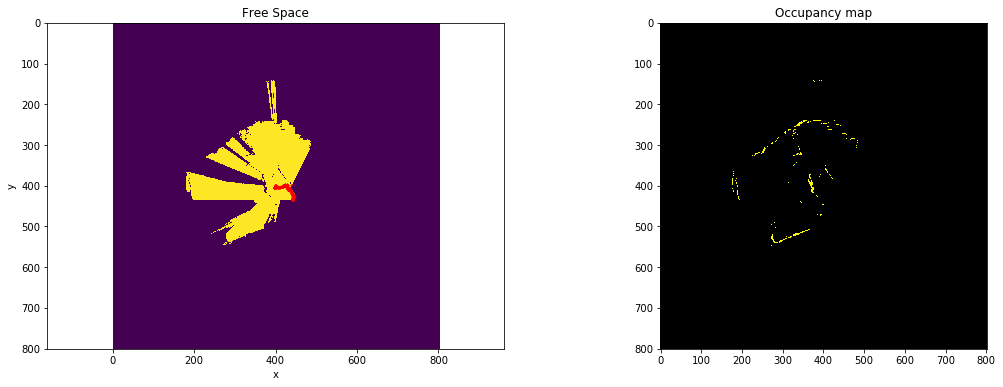

 66%|██████▋   | 7999/12047 [20:50<11:18,  5.96it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


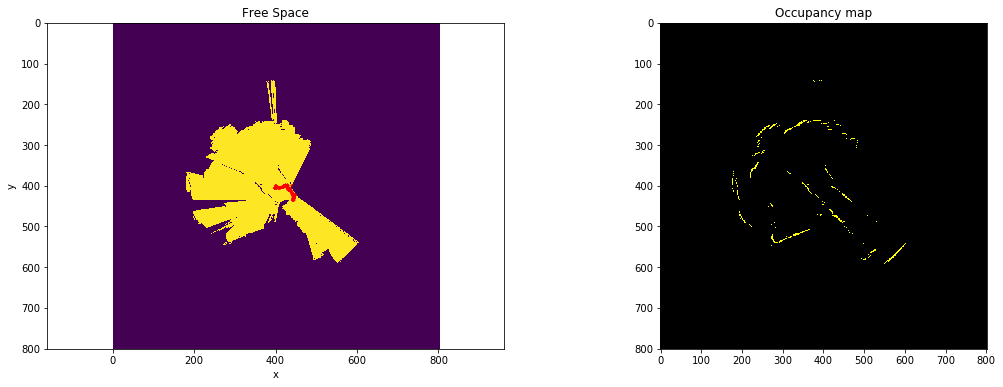

 75%|███████▍  | 8999/12047 [23:28<09:29,  5.36it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


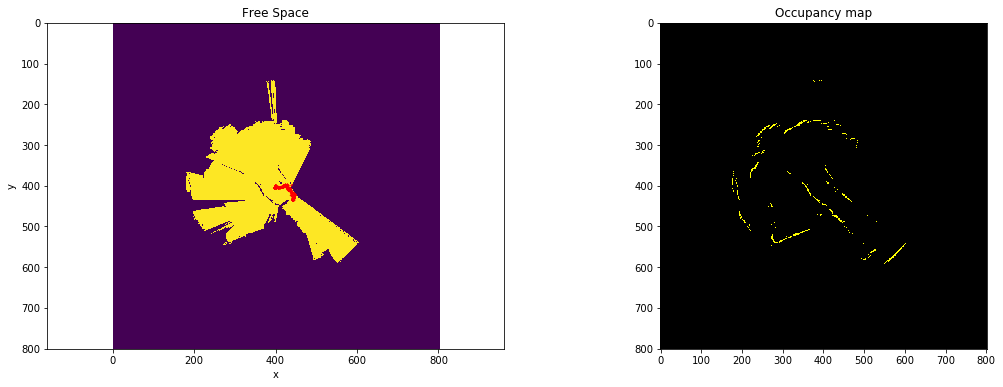

 83%|████████▎ | 9999/12047 [26:02<05:52,  5.80it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


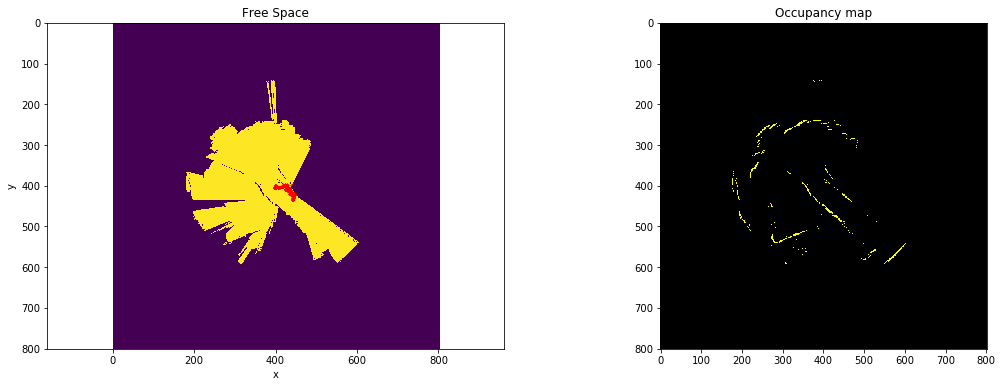

 91%|█████████▏| 10999/12047 [28:42<02:27,  7.11it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


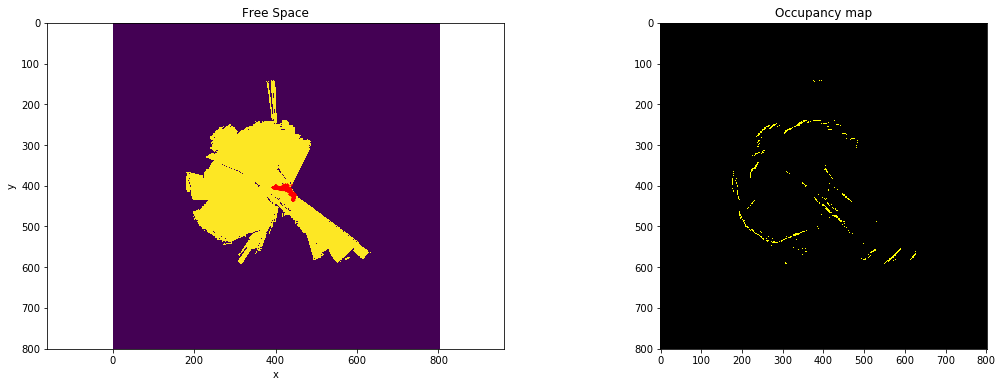

100%|█████████▉| 11999/12047 [31:19<00:07,  6.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


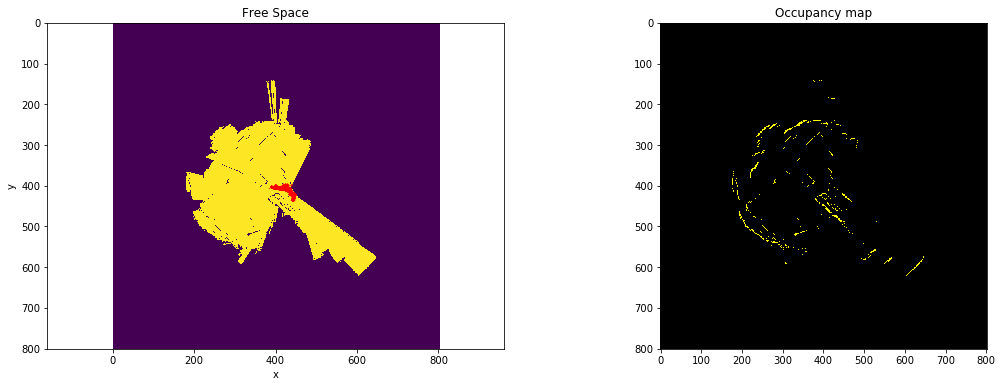

100%|█████████▉| 12046/12047 [31:28<00:00,  5.94it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


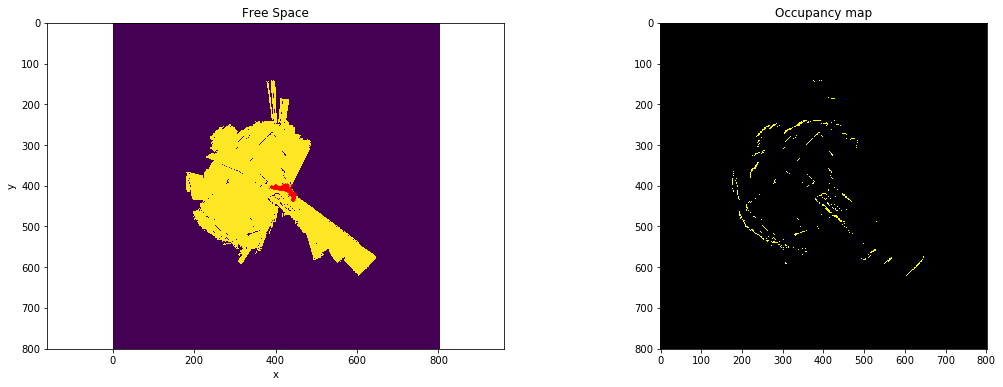

100%|██████████| 12047/12047 [31:29<00:00,  2.54it/s]

Time taken 1889.3571939468384


In [2]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    #MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 20
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #### Update the Map based on Lidar Reading #####
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.003,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.001,1))) #Particular noise to x,y
            #part_states[:,particle] = (noise + cur_pose).T
            part_states[:,particle] = noise + part_states[:,particle] + np_lidar_delta_pose[:,cur_scan]
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
        
        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if((cur_scan % 1000 == 0) or (cur_scan == np_lidar_scan.shape[1]-1)) :
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.5 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)

    ######## Update #########


        
def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 

    ######## Drop Points that have negative z value in world frame ########
    world_T = world.T
    world_corrected = world_T[np.where(world[2,:] > 0)]
    world_corrected = world_corrected.T

    xs0 = world_corrected[0,:].reshape(1,world_corrected.shape[1])
    ys0 = world_corrected[1,:].reshape(1,world_corrected.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

      #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(9))
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = np.where(MAP["log_odds"] > 100, np.full(map_shape,100),MAP["log_odds"])
        MAP["log_odds"] = np.where(MAP["log_odds"] < -100, np.full(map_shape,-100),MAP["log_odds"])
        #print("Min Log Odds",np.min(MAP["log_odds"]))
        #print("Max Log Odds",np.max(MAP["log_odds"]))
        #print("Sum",np.min(MAP["log_odds"]) + np.max(MAP["log_odds"]))
        #MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)

     #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          #plt.plot(yis,xis,'.k')
          plt.scatter(MAP['x_loc'],MAP['y_loc'],s=0.1,c='r')

          map_threshold = np.zeros((map_shape))
          map_threshold = np.where(MAP['log_odds'] < 0,  np.full(map_shape,1),np.zeros(map_shape))

          plt.imshow(map_threshold)
          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          plt.xlabel("x")
          plt.ylabel("y")
          plt.title("Free Space")
          plt.axis('equal')

          #plot map
          map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold[:,:,0] = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
          map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    if(update_log_odds == True):
        return MAP
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [2]:
# scan_map = np.zeros_like(im)
# scan_map[ix[valid], iy[valid]] = True
# cpr[jx, jy] = np.sum(np.logical_and(im, scan_map))
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt
######## Having a lower log odds will help because any bad particle can influence a lot and 
######### having larger cap will prevent some particles destroying the map########




  0%|          | 0/12047 [00:00<?, ?it/s]

Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [02:39<20:43,  8.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


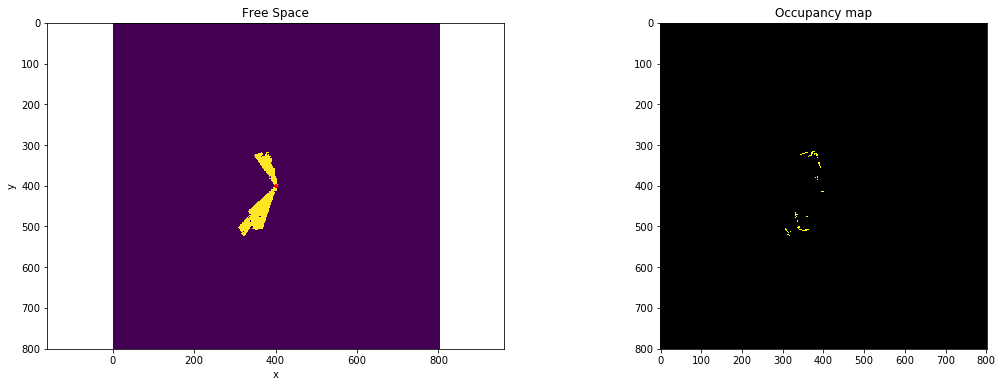

 17%|█▋        | 1999/12047 [05:16<26:05,  6.42it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


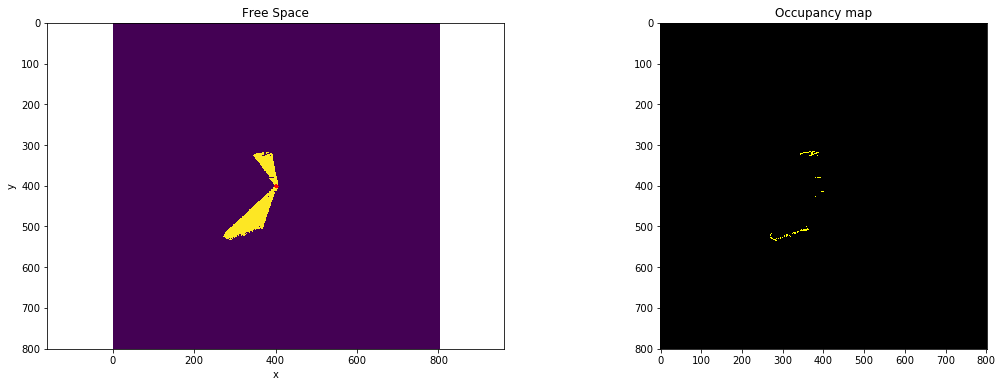

 25%|██▍       | 2999/12047 [07:51<25:05,  6.01it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


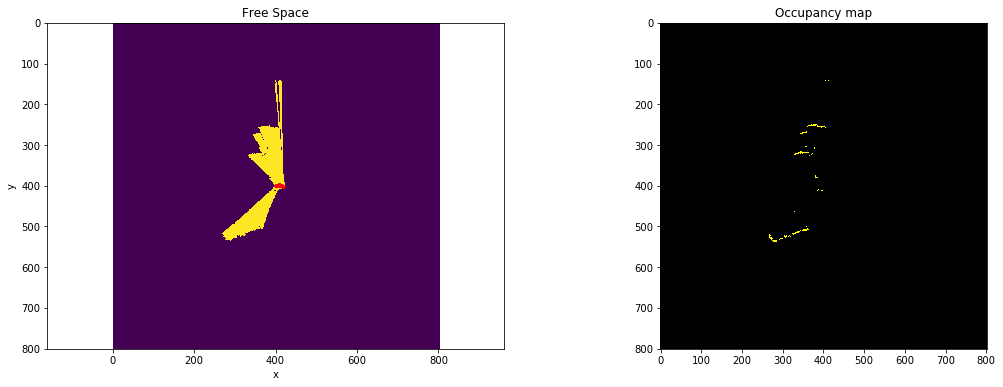

 33%|███▎      | 3999/12047 [10:30<22:31,  5.96it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


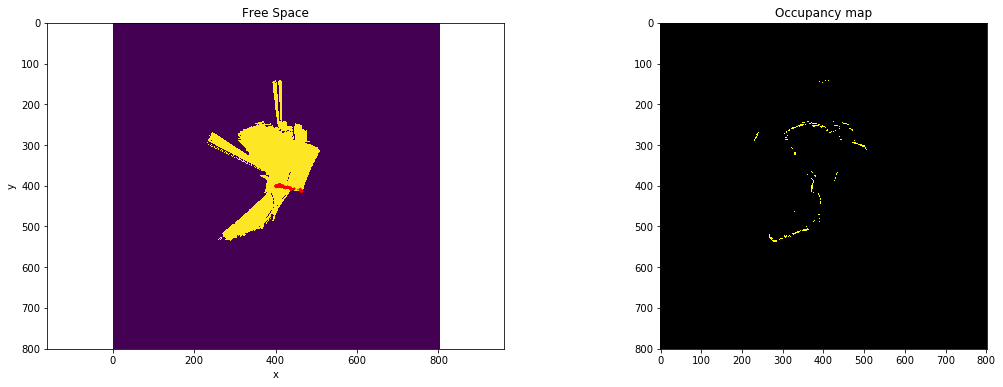

 41%|████▏     | 4999/12047 [13:07<19:25,  6.05it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


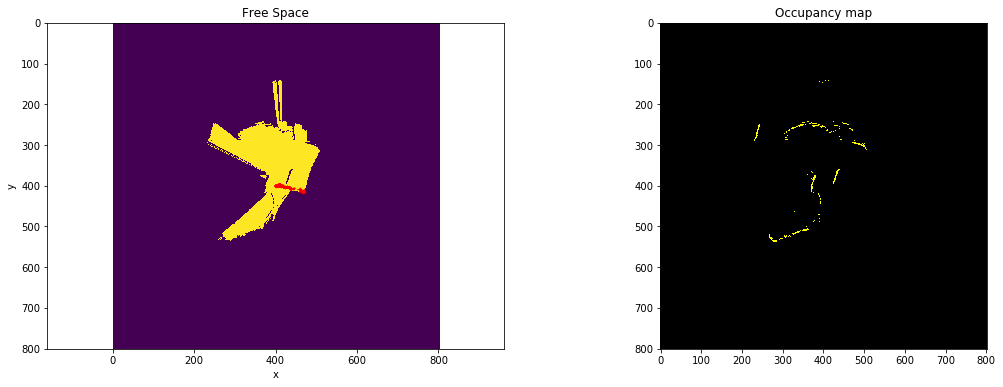

 50%|████▉     | 5999/12047 [15:46<17:19,  5.82it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


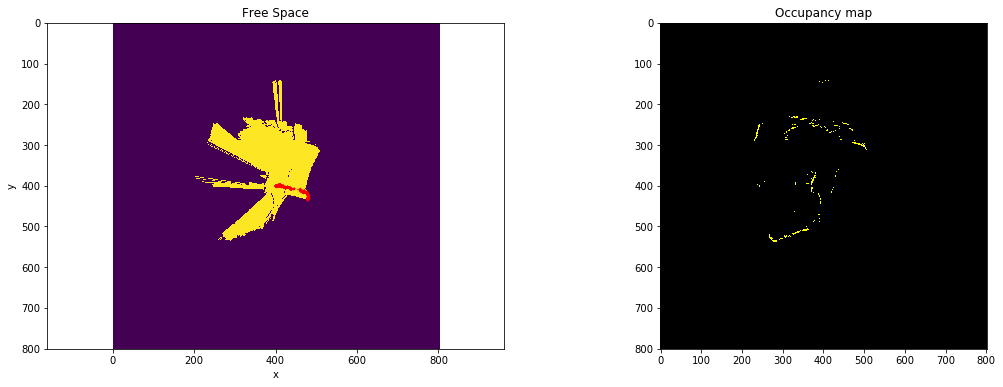

 58%|█████▊    | 6999/12047 [18:22<12:50,  6.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


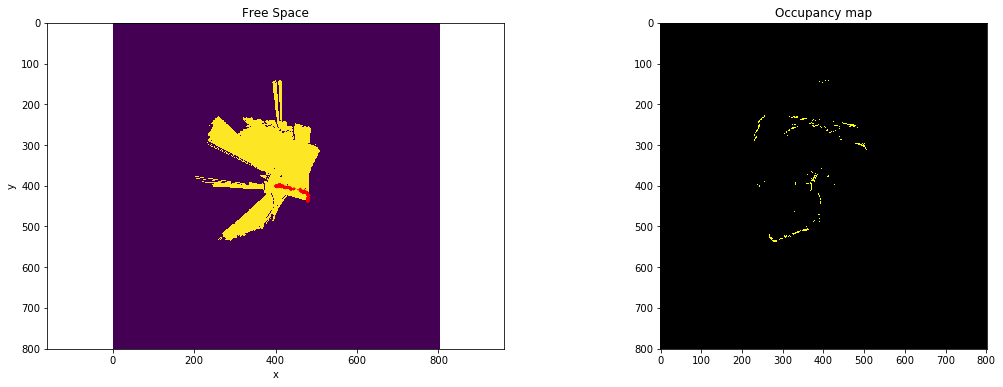

 66%|██████▋   | 7999/12047 [20:55<10:57,  6.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


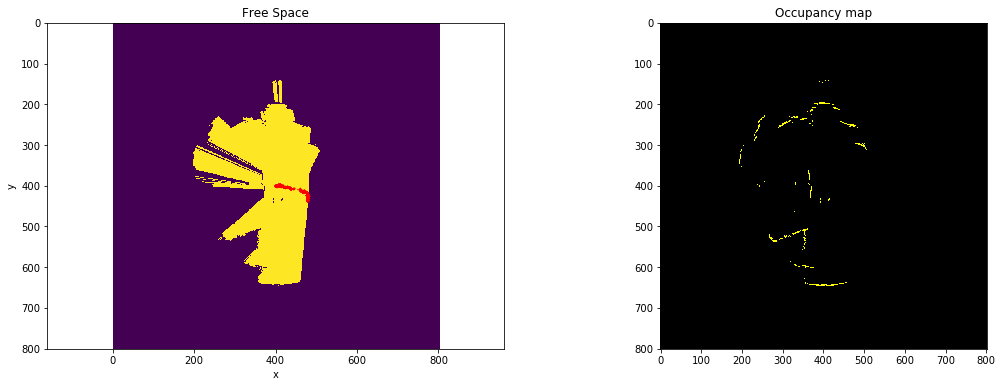

 75%|███████▍  | 8999/12047 [23:29<07:00,  7.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


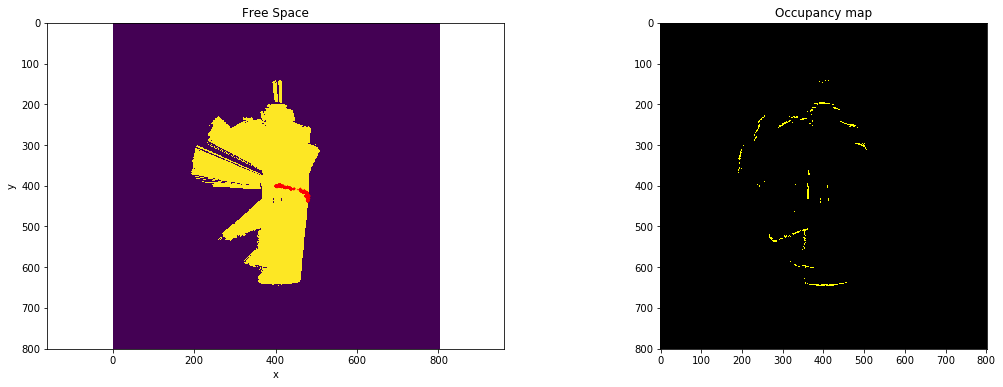

 83%|████████▎ | 9999/12047 [26:03<04:47,  7.12it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


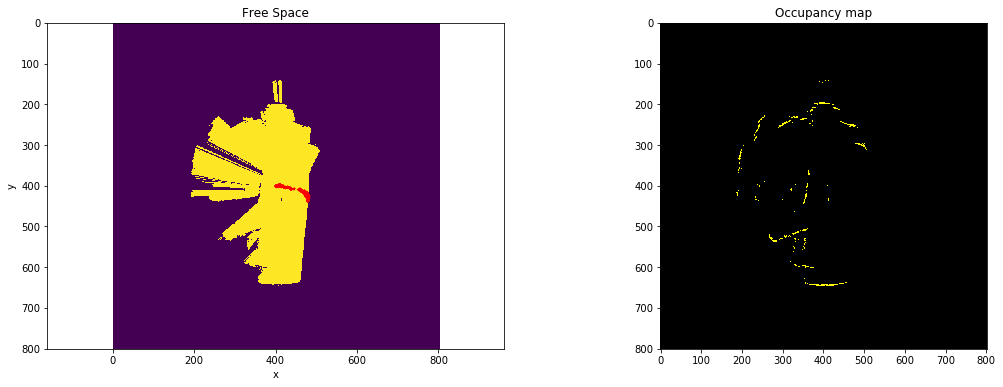

 91%|█████████▏| 10999/12047 [28:39<01:48,  9.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


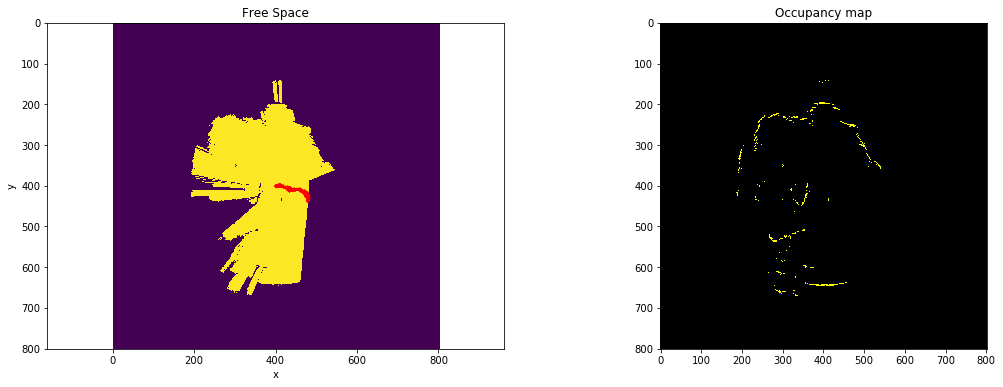

100%|█████████▉| 11999/12047 [31:18<00:08,  5.36it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


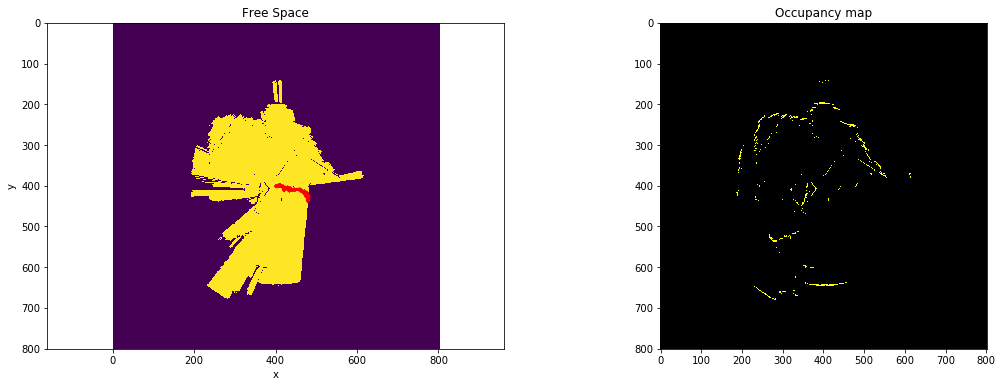

100%|█████████▉| 12046/12047 [31:25<00:00,  7.23it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


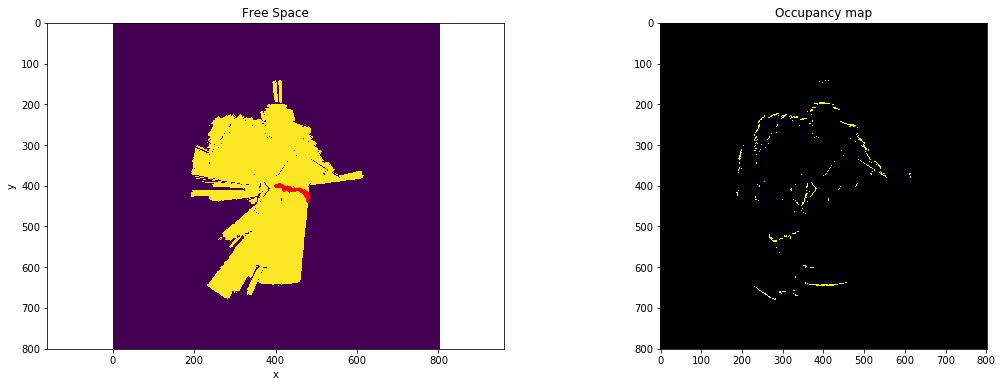

100%|██████████| 12047/12047 [31:26<00:00,  3.06it/s]

Time taken 1886.664799451828


In [3]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    #MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 20
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #### Update the Map based on Lidar Reading #####
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.003,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.001,1))) #Particular noise to x,y
            #part_states[:,particle] = (noise + cur_pose).T
            part_states[:,particle] = noise + part_states[:,particle] + np_lidar_delta_pose[:,cur_scan]
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
        
        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if((cur_scan % 1000 == 0) or (cur_scan == np_lidar_scan.shape[1]-1)) :
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.5 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)

    ######## Update #########


        
def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 

    ######## Drop Points that have negative z value in world frame ########
    world_T = world.T
    world_corrected = world_T[np.where(world[2,:] > 0)]
    world_corrected = world_corrected.T

    xs0 = world_corrected[0,:].reshape(1,world_corrected.shape[1])
    ys0 = world_corrected[1,:].reshape(1,world_corrected.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

      #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(6))
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = np.where(MAP["log_odds"] > 100, np.full(map_shape,100),MAP["log_odds"])
        MAP["log_odds"] = np.where(MAP["log_odds"] < -100, np.full(map_shape,-100),MAP["log_odds"])
        #print("Min Log Odds",np.min(MAP["log_odds"]))
        #print("Max Log Odds",np.max(MAP["log_odds"]))
        #print("Sum",np.min(MAP["log_odds"]) + np.max(MAP["log_odds"]))
        #MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)

     #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          #plt.plot(yis,xis,'.k')
          plt.scatter(MAP['x_loc'],MAP['y_loc'],s=0.1,c='r')

          map_threshold = np.zeros((map_shape))
          map_threshold = np.where(MAP['log_odds'] < 0,  np.full(map_shape,1),np.zeros(map_shape))

          plt.imshow(map_threshold)
          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          plt.xlabel("x")
          plt.ylabel("y")
          plt.title("Free Space")
          plt.axis('equal')

          #plot map
          map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold[:,:,0] = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
          map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    if(update_log_odds == True):
        return MAP
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [1]:
# scan_map = np.zeros_like(im)
# scan_map[ix[valid], iy[valid]] = True
# cpr[jx, jy] = np.sum(np.logical_and(im, scan_map))
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt
######### Lowering the threshold to 50########
######## Having a lower log odds did not help and the particles were forgetting the map ########### 




  0%|          | 0/12047 [00:00<?, ?it/s]

Read Lidar Data
Map intialized
Loaded Odometry data


  8%|▊         | 999/12047 [00:54<09:17, 19.82it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


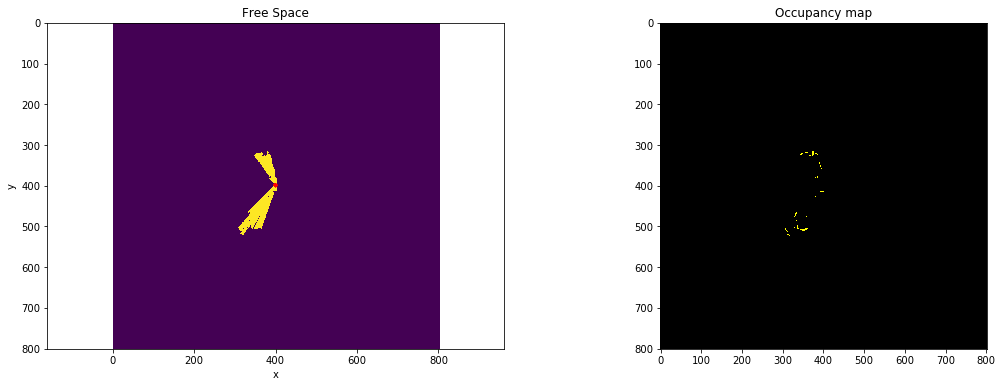

 17%|█▋        | 1998/12047 [01:46<08:39, 19.35it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


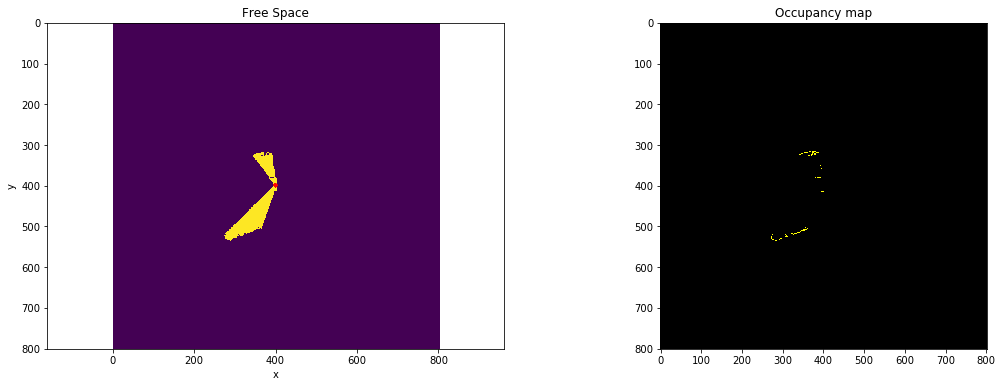

 25%|██▍       | 2998/12047 [02:36<07:39, 19.67it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


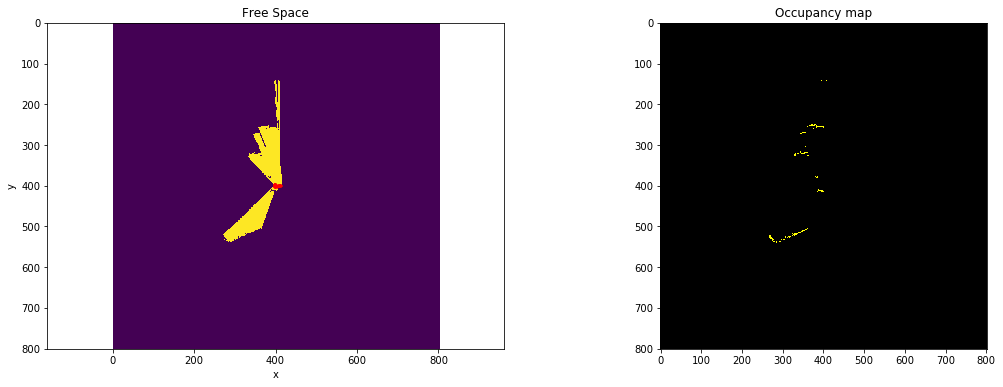

 33%|███▎      | 3999/12047 [03:25<07:15, 18.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


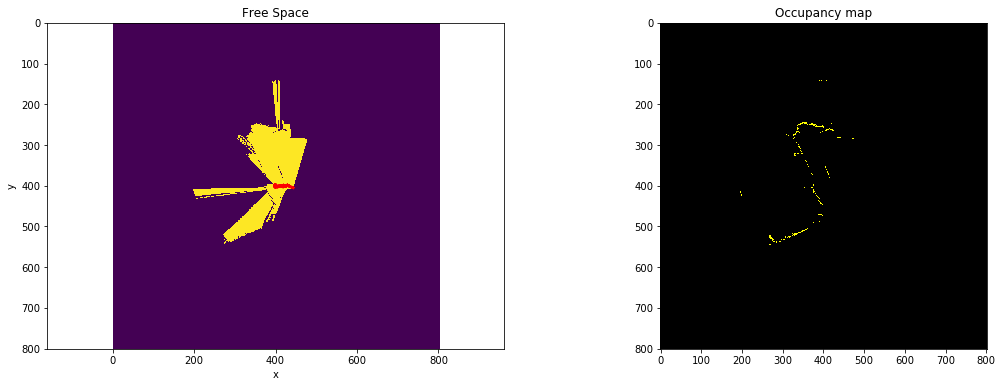

 41%|████▏     | 4998/12047 [04:17<06:28, 18.14it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


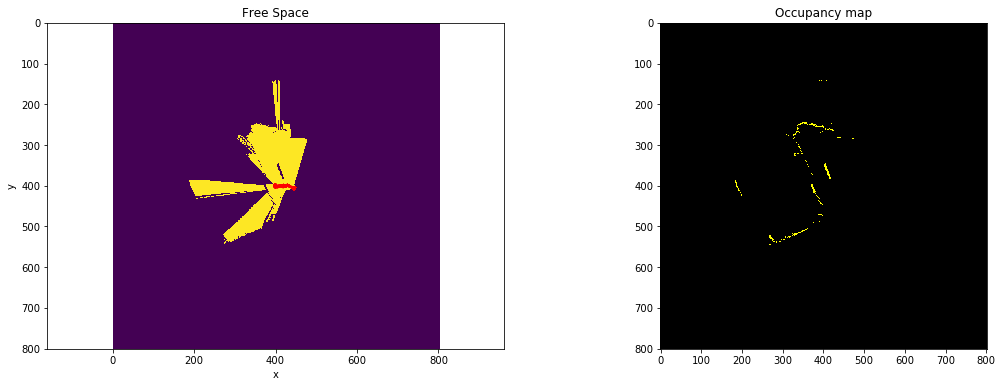

 50%|████▉     | 5998/12047 [05:09<05:10, 19.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


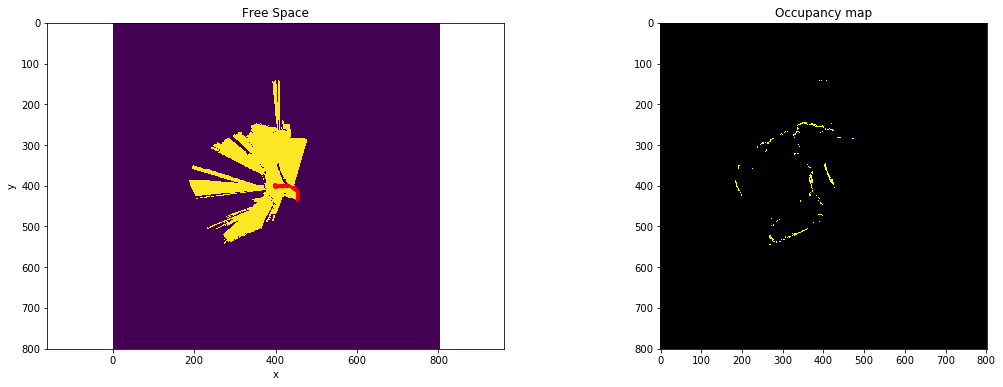

 58%|█████▊    | 6998/12047 [06:01<03:19, 25.32it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


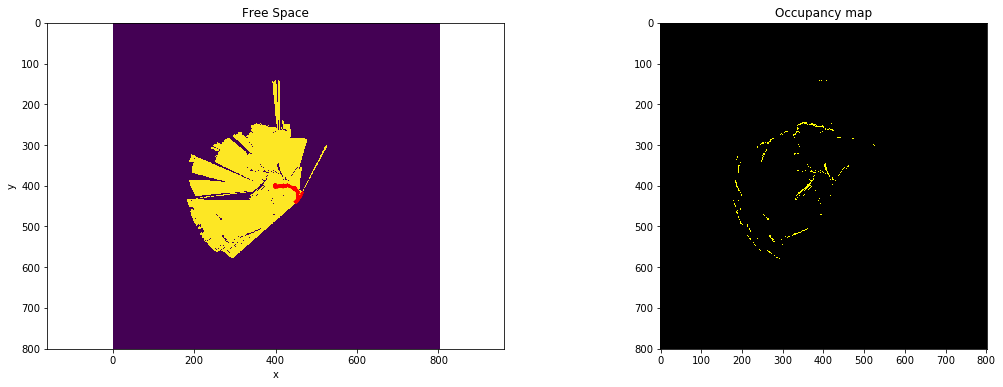

 66%|██████▋   | 7999/12047 [06:54<03:40, 18.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


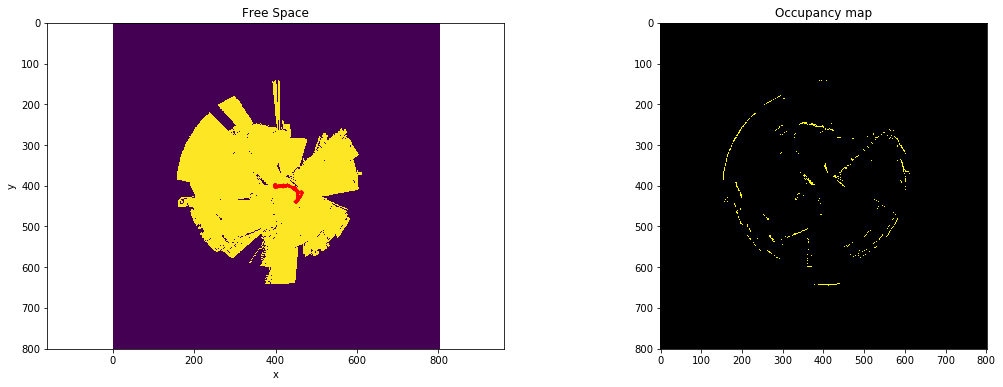

 75%|███████▍  | 8999/12047 [07:44<02:32, 19.96it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


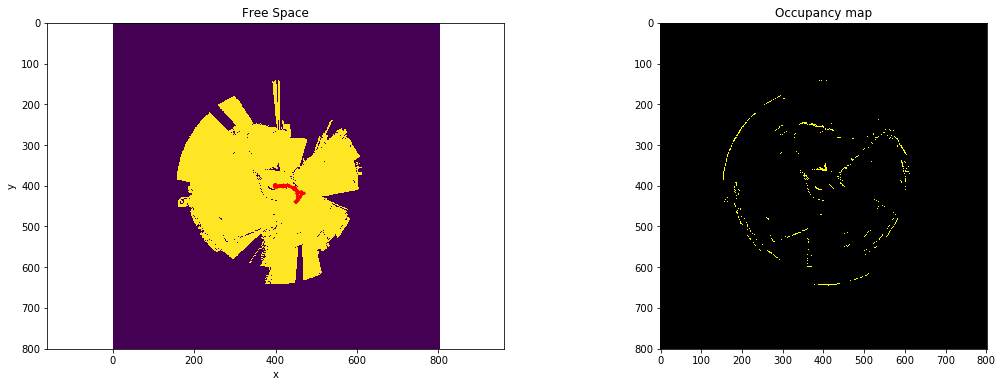

 83%|████████▎ | 9999/12047 [08:35<01:46, 19.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


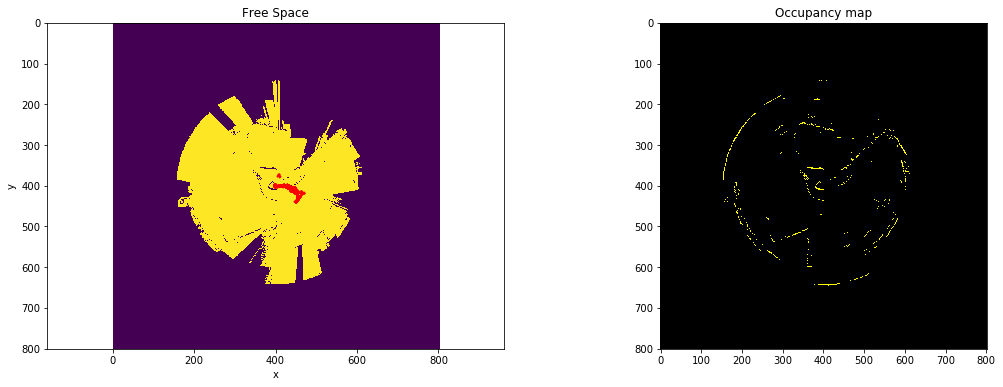

 91%|█████████▏| 10999/12047 [09:28<00:43, 23.99it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


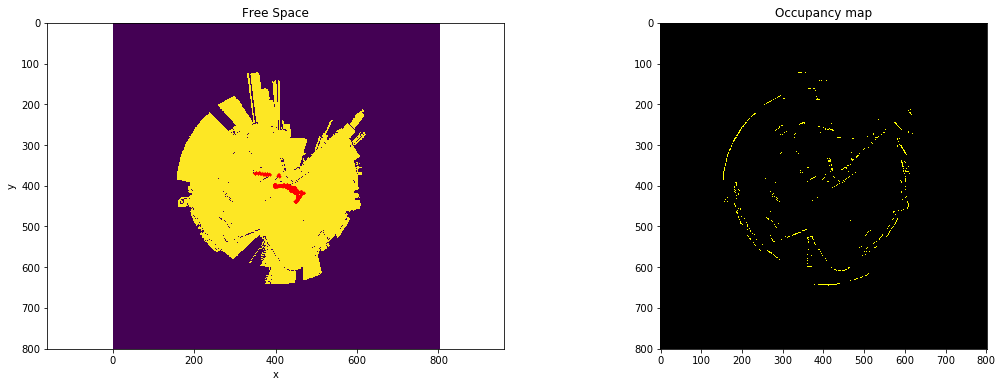

100%|█████████▉| 11999/12047 [10:19<00:02, 19.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


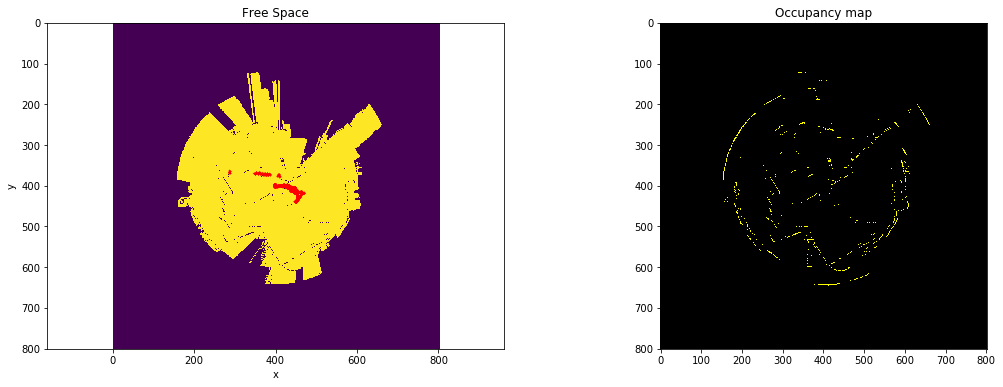

100%|█████████▉| 12045/12047 [10:22<00:00, 19.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


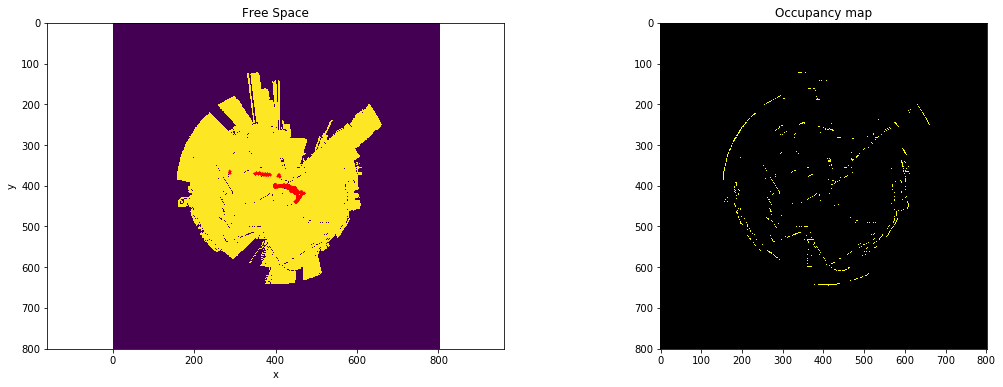

100%|██████████| 12047/12047 [10:23<00:00,  7.16it/s]

Time taken 623.4102976322174


In [2]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    #MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 5
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #### Update the Map based on Lidar Reading #####
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.003,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.001,1))) #Particular noise to x,y
            #part_states[:,particle] = (noise + cur_pose).T
            part_states[:,particle] = noise + part_states[:,particle] + np_lidar_delta_pose[:,cur_scan]
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
        
        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if((cur_scan % 1000 == 0) or (cur_scan == np_lidar_scan.shape[1]-1)) :
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.5 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)

    ######## Update #########


        
def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 

    ######## Drop Points that have negative z value in world frame ########
    world_T = world.T
    world_corrected = world_T[np.where(world[2,:] > 0)]
    world_corrected = world_corrected.T

    xs0 = world_corrected[0,:].reshape(1,world_corrected.shape[1])
    ys0 = world_corrected[1,:].reshape(1,world_corrected.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

      #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(9))
        log_thrs = 50
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = np.where(MAP["log_odds"] > log_thrs, np.full(map_shape,log_thrs),MAP["log_odds"])
        MAP["log_odds"] = np.where(MAP["log_odds"] < -log_thrs, np.full(map_shape,-log_thrs),MAP["log_odds"])
        #print("Min Log Odds",np.min(MAP["log_odds"]))
        #print("Max Log Odds",np.max(MAP["log_odds"]))
        #print("Sum",np.min(MAP["log_odds"]) + np.max(MAP["log_odds"]))
        #MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)

     #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          #plt.plot(yis,xis,'.k')
          plt.scatter(MAP['x_loc'],MAP['y_loc'],s=0.1,c='r')

          map_threshold = np.zeros((map_shape))
          map_threshold = np.where(MAP['log_odds'] < 0,  np.full(map_shape,1),np.zeros(map_shape))

          plt.imshow(map_threshold)
          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          plt.xlabel("x")
          plt.ylabel("y")
          plt.title("Free Space")
          plt.axis('equal')

          #plot map
          map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold[:,:,0] = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
          map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    if(update_log_odds == True):
        return MAP
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)



In [ ]:
# scan_map = np.zeros_like(im)
# scan_map[ix[valid], iy[valid]] = True
# cpr[jx, jy] = np.sum(np.logical_and(im, scan_map))
%matplotlib inline
import numpy as np
from matplotlib import  pyplot as plt
######### Increasing the threshold to 100########
######## Having a lower log odds did not help and the particles were forgetting the map ########### 

In [ ]:
from  load_data import *
from p2_utils import *
import numpy as np
import os
import cv2
import math
import time
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from scipy.special import softmax

def init_map():
    MAP = {}
    MAP['res']   = 0.05 #meters
    MAP['xmin']  = -20  #meters
    MAP['ymin']  = -20
    MAP['xmax']  =  20
    MAP['ymax']  =  20 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8
    MAP['log_odds'] = np.zeros((MAP['sizex'],MAP['sizey'])) #DATA TYPE: char or int8
    #MAP['robo_state'] = [0,0,0]
    MAP['x_loc'] = []
    MAP['y_loc'] = []
    
    return MAP

def slam(lidar_data,odometry_data,MAP):

    ############## Initializations ##############
    num_pose = 1081#len(lidar_data[0]['delta_pose'])
    plot_en = 1
    num_particles = 5
    part_states = np.zeros((3,num_particles))
    part_corr = np.zeros(num_particles)
    part_wghts = np.ones(num_particles) / num_particles
    

    ############### Sanity ##############
    np_lidar_delta_pose = np.zeros((3,len(lidar_data)))
    np_lidar_scan = np.zeros((num_pose,len(lidar_data)))
    for i in range(len(lidar_data)):
        np_lidar_delta_pose[:,i] = lidar_data[i]['delta_pose'][0].T
        np_lidar_scan[:,i] = lidar_data[i]['scan']


    xy_noise_pwr = 1#1e3
    yaw_noise_pwr =1# 1e-7
    start_time = time.time()
    cur_scan = 0
    particle_ids = np.arange(num_particles)
    ###### Initial Scan ######

    cur_pose = np_lidar_delta_pose[:,cur_scan]
    MAP = update_and_map(np_lidar_scan[:,cur_scan],cur_pose,MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True)

    #for cur_scan in range(1,np_lidar_scan.shape[1]):
    for cur_scan in tqdm(range(1,np_lidar_scan.shape[1])):
    #for cur_scan in range(1,np_lidar_scan.shape[1]):
        #### Update the Map based on Lidar Reading #####
        for particle in particle_ids:
            ######## Predict #########
            noise = xy_noise_pwr * np.random.normal(0,0.003,2)#Particular noise to x,y
            noise = np.hstack((noise,yaw_noise_pwr * np.random.normal(0,0.001,1))) #Particular noise to x,y
            #part_states[:,particle] = (noise + cur_pose).T
            part_states[:,particle] = noise + part_states[:,particle] + np_lidar_delta_pose[:,cur_scan]
            ######## Update Weights#########
            MAP,part_corr[particle] = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,particle],MAP,odometry_data['head_angles'][:,cur_scan])
        
        ####### Update Map with best particle ########
        corr_softmax = softmax(part_corr)
        part_wghts = part_wghts * corr_softmax
        part_wghts /= np.sum(part_wghts)
        best_particle = np.argmax(corr_softmax) 

#         if(cur_scan == (np_lidar_scan.shape[1]-1)):
        if((cur_scan % 1000 == 0) or (cur_scan == np_lidar_scan.shape[1]-1)) :
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 1)
        else:
            MAP = update_and_map(np_lidar_scan[:,cur_scan],part_states[:,best_particle],MAP,odometry_data['head_angles'][:,cur_scan],update_log_odds = True,plot_en = 0)

        ####### ReSampling ######
        N_eff = 1/(np.linalg.norm(part_wghts) ** 2)
        if(N_eff < 0.5 * num_particles):
            part_wghts = np.ones(num_particles) / num_particles
            particle_ids = np.random.choice(num_particles,num_particles,part_wghts.squeeze)
            part_states_T = part_states.T
            part_states = part_states_T[particle_ids].T

    print("Time taken",time.time()-start_time)

    ######## Update #########


        
def update_and_map(ranges,pose,MAP,head_angles,update_log_odds=False,plot_en=0):
    #dataIn = io.loadmat("lidar/train_lidar0.mat")
    angles = np.array([np.arange(-135,135.25,0.25)*np.pi/180.]).T
    ranges = ranges.reshape((ranges.shape[0],1))
    #ranges = np.double(dataIn['lidar'][0][110]['scan'][0][0]).T
    
    # take valid indices
    valid_range = np.logical_and((ranges < 30),(ranges> 0.1))
    ranges = ranges[valid_range]
    angles = angles[valid_range]
    
    # xy position in the sensor frame
    xs0 = np.array([ranges*np.cos(angles)])
    ys0 = np.array([ranges*np.sin(angles)])
    scan_ranges = np.vstack((xs0,ys0))
    dummy = np.vstack((xs0*0,ys0*0))
    scan_ranges = np.vstack((scan_ranges,dummy))
    world = convert2world_frame(scan_ranges,pose,head_angles) 

    ######## Drop Points that have negative z value in world frame ########
    world_T = world.T
    world_corrected = world_T[np.where(world[2,:] > 0)]
    world_corrected = world_corrected.T

    xs0 = world_corrected[0,:].reshape(1,world_corrected.shape[1])
    ys0 = world_corrected[1,:].reshape(1,world_corrected.shape[1])
    # convert position in the map frame here 
     
    #Y = np.concatenate([np.concatenate([xs0,ys0],axis=0),np.zeros(xs0.shape)],axis=0)
    
    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1
    
    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[0][indGood[0]],yis[0][indGood[0]]]=1
      
    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map
    
    x_range = np.arange(-0.2,0.2+0.05,0.05)
    y_range = np.arange(-0.2,0.2+0.05,0.05)
    
    map_shape = MAP['map'].shape

      #################################################
    
    ######## Update Log-Odds #########
    if(update_log_odds == True):
        free_cells = np.zeros(map_shape)
        occupied_cells = np.zeros(map_shape)
        ################## Bug of the year was found here ##############
        #pose = pose.astype(np.int16)
        pose_x = np.ceil((pose[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
        pose_y = np.ceil((pose[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

      
        for scan in range(xis.shape[1]):
            if(yis[0,scan] >  MAP['sizey'] or xis[0,scan] >  MAP['sizex']) :
                pass
            else:
              free_cells = cv2.line(free_cells,(pose_x,pose_y),(xis[0,scan],yis[0,scan]),color = 1,thickness=1)
              occupied_cells[yis[0,scan],xis[0,scan]] = 1
              #free_cells = cv2.line(free_cells,(pose_y,pose_x),(yis[0,scan],xis[0,scan]),color = 255,thickness=1)
              #occupied_cells[xis[0,scan],yis[0,scan]] = 1
        #occupied_cells[pose_y,pose_x] = 1
      
        sensor_confidence = np.full(map_shape,np.log(9))
        log_thrs = 50
        MAP["log_odds"] += 2 * occupied_cells * sensor_confidence #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = MAP['log_odds'] - free_cells * sensor_confidence  #Because we are subtracting one value at occupied free cell
        MAP["log_odds"] = np.where(MAP["log_odds"] > log_thrs, np.full(map_shape,log_thrs),MAP["log_odds"])
        MAP["log_odds"] = np.where(MAP["log_odds"] < -log_thrs, np.full(map_shape,-log_thrs),MAP["log_odds"])
        #print("Min Log Odds",np.min(MAP["log_odds"]))
        #print("Max Log Odds",np.max(MAP["log_odds"]))
        #print("Sum",np.min(MAP["log_odds"]) + np.max(MAP["log_odds"]))
        #MAP['robo_state'] = pose
        MAP['x_loc'].append(pose_x)
        MAP['y_loc'].append(pose_y)

     #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    ################# Plot ################
    if(plot_en):
          fig = plt.figure(figsize=(18,6))
          #plot original lidar points
          ax1 = fig.add_subplot(121)
          #plt.plot(xs0,ys0,'.k')
          #plt.plot(yis,xis,'.k')
          plt.scatter(MAP['x_loc'],MAP['y_loc'],s=0.1,c='r')

          map_threshold = np.zeros((map_shape))
          map_threshold = np.where(MAP['log_odds'] < 0,  np.full(map_shape,1),np.zeros(map_shape))

          plt.imshow(map_threshold)
          #plt.plot(xs_leg,ys_leg,'.k')
          #plt.scatter(0,0,s=30,c='r')

          #plt.scatter(MAP['robo_xloc'],MAP['robo_yloc'],s=0.01,c='r')
          #plt.scatter(MAP['robo_state'][0],MAP['robo_state'][1],s=10,c='r')
          #robo_x += np_lidar_delta_pose[0,cur_scan]
          #robo_y += np_lidar_delta_pose[1,cur_scan]

          plt.xlabel("x")
          plt.ylabel("y")
          plt.title("Free Space")
          plt.axis('equal')

          #plot map
          map_threshold = np.zeros((map_shape[0],map_shape[1],3))
          map_threshold[:,:,0] = np.where(MAP['log_odds'] > 0,  np.full(map_shape,255),np.zeros(map_shape))
          map_threshold[:,:,1] = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
          ax2 = fig.add_subplot(122)
          plt.imshow(map_threshold)
          plt.title("Occupancy map")
          #image_name = 'image_stamped'+int2str(some_weird_counter)+'.png'
          #plt.savefig()
          
          #plot correlation
          #ax3 = fig.add_subplot(133,projection='3d')
          #X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
          #ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
          #plt.title("Correlation coefficient map")

          plt.show()


    if(update_log_odds == True):
        return MAP
    
    #TODO: Cap log odds, Threshold Map also
    ####### Perform Correlation #######
    
    
    Y = np.vstack((xs0,ys0))
      
    #correlation = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    #print(map_threshold.shape)
    #print("range",np.min(MAP['log_odds']),np.max(MAP['log_odds']))

    plot_en = 0
    if(plot_en == 10):
        plt.subplot(121)
        plt.imshow(MAP['log_odds'],cmap='gray')
        plt.subplot(122)
        plt.imshow(map_threshold)
        plt.show()
    #correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,y_range)
    map_threshold = np.where(MAP['log_odds'] > 0, np.ones(map_shape),np.zeros(map_shape))
    correlation = mapCorrelation(map_threshold,x_im,y_im,Y,x_range,x_range)
    #Y = np.vstack((yis,xis))
    #correlation = mapCorrelation(map_threshold,y_im,x_im,Y,y_range,x_range)
    
    return MAP,correlation

      #MAP['log_odds'] = np.logical_or(MAP['log_odds'],cv2.line(empty_img,start,end)



  
#  c = mapCorrelation(MAP['map'],x_im,y_im,Y[0:3,:],x_range,y_range)
#  
#  c_ex = np.array([[3,4,8,162,270,132,18,1,0],
#		  [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
#		  [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
#		  [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
#		  [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
#		  [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
#		  [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
#		  [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
#		  [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])
#		  
#  if np.sum(c==c_ex) == np.size(c_ex):
#	  print("...Test passed.")
#  else:
#	  print("...Test failed. Close figures to continue tests.")	
#
#  
def polar2cart(lidar_data):
    import math
    theta_temp = np.arange(0, math.radians(271),math.radians(270/1080))
    theta = theta_temp[:lidar_data.shape[0]]
    return np.vstack((lidar_data * np.cos(theta),lidar_data * np.sin(theta)))

def convert2world_frame(lidar_scan,lidar_pose,head_angles):
    '''
    This takes in the lidar frame reading and computes the world frame readings
    Ideally the z axis should not change
    '''

    #Pose from lidar to head
    #print("Pose is ",lidar_pose)
    lid2head_pose = np.hstack((np.eye(3),np.array([0,0,0.15]).reshape(3,1)))
    lid2head_pose = np.vstack((lid2head_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from head to body
    yaw,pit = head_angles
    rot_yaw = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    rot_pit = np.array([[np.cos(pit),0,np.sin(pit)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])#.astype(float)
    head2body_rot = rot_yaw @ rot_pit
    head2body_pose = np.hstack((head2body_rot,np.array([0,0,0.33]).reshape(3,1)))
    head2body_pose = np.vstack((head2body_pose,np.array([0,0,0,1]).reshape(1,4)))

    #Pose from body to world

    yaw = lidar_pose[2]
    body2world_rot = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])#.astype(float)
    body2world_pose = np.hstack((body2world_rot,np.array([lidar_pose[0],lidar_pose[1],0.93]).reshape(3,1)))
    body2world_pose = np.vstack((body2world_pose,np.array([0,0,0,1]).reshape(1,4)))
      

    #Total pose
    tot_pose = body2world_pose @ head2body_pose @ lid2head_pose
    return tot_pose @ lidar_scan




if __name__ == '__main__':
    print('\007')
    lidar_data = get_lidar("lidar/train_lidar0")
    #Pose is already in world frame and scan has to be shifted to world frame
    print("Read Lidar Data")

    MAP = init_map()
    print("Map intialized")
    #lidar_data = sorted(lidar_data.items(),key = lambda k:  k['t'][0])
    #print("Sorted Lidar Data")
    odometry_data = get_joint("joint/train_joint0")
    print("Loaded Odometry data")

    slam(lidar_data,odometry_data,MAP)

